# Adverse Reaction Classification and Clusters of the COVID-19 Vaccine: Potential Clinical Prediction Tool

### Andrea Gomez, Dung Mai, Mariana Maroto
### Graduate Center, CUNY - Machine Learning CSCI 740 Spring 2021

Our application project clusters and classifies COVID-19 vaccine adverse reactions. The purpose of the project is having a detailed understanding of the common types of adverse reactions and  identifying which adverse reactions are in need of immediate care. This project suggests a two-step approach. First, using an unsupervised machine learning algorithm (clustering) to segment adverse reactions into groups. This will give us the most common symptoms for each group. Second, using symptoms, along with additional patient information (gender, age, allergies) and vaccine manufacturer information, we will predict the need of urgent medical care by using fatalities and hospital visits. 

The dataset is provided by the Vaccine Adverse Event Reporting System VAERS and contains reports about adverse events that may be associated with COVID-19 vaccines. The database we chose was the dataset provided for the current year 2021, considering that our goal is to explore reactions due to Covid vaccines. The data contains reports processed as of 3/26/2021. 

Dataset Source: VAERS - Vaccine Adverse Event Reporting System. Data Retrieve on 4/8/2021 https://vaers.hhs.gov/data/datasets.html

# Clean each dataset

In [1]:
import pandas as pd
import numpy as np

all_data =  pd.read_csv('2021VAERSDATA.csv', sep=",", encoding = "ISO-8859-1")
symptoms_data = pd.read_csv('2021VAERSSYMPTOMS.csv', sep=",", encoding = "ISO-8859-1")
vax_data = pd.read_csv('2021VAERSVAX.csv', sep=",", encoding = "ISO-8859-1")

print('Main Dataset Size:', all_data.shape)
print('Symptoms Dataset Size:', symptoms_data.shape)
print('Vaccine Info Dataset Size:', vax_data.shape)

Main Dataset Size: (40348, 35)
Symptoms Dataset Size: (56533, 11)
Vaccine Info Dataset Size: (40937, 8)


C:\Users\andre\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (7,12,23) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## 1. all_data dataset

This dataset contains data like gender, age, and other useful features.

In [2]:
all_data.head()

,VAERS_ID,RECVDATE,STATE,AGE_YRS,CAGE_YR,CAGE_MO,SEX,RPT_DATE,SYMPTOM_TEXT,DIED,...,CUR_ILL,HISTORY,PRIOR_VAX,SPLTTYPE,FORM_VERS,TODAYS_DATE,BIRTH_DEFECT,OFC_VISIT,ER_ED_VISIT,ALLERGIES
0,916600,01/01/2021,TX,33.0,33.0,NaN,F,NaN,Right side of epiglottis swelled up and hinder...,NaN,...,None,None,NaN,NaN,2,01/01/2021,NaN,Y,NaN,Pcn and bee venom
1,916601,01/01/2021,CA,73.0,73.0,NaN,F,NaN,Approximately 30 min post vaccination administ...,NaN,...,Patient residing at nursing facility. See pati...,Patient residing at nursing facility. See pati...,NaN,NaN,2,01/01/2021,NaN,Y,NaN,"""Dairy"""
2,916602,01/01/2021,WA,23.0,23.0,NaN,F,NaN,"About 15 minutes after receiving the vaccine, ...",NaN,...,None,None,NaN,NaN,2,01/01/2021,NaN,NaN,Y,Shellfish
3,916603,01/01/2021,WA,58.0,58.0,NaN,F,NaN,"extreme fatigue, dizziness,. could not lift my...",NaN,...,kidney infection,"diverticulitis, mitral valve prolapse, osteoar...","got measles from measel shot, mums from mumps ...",NaN,2,01/01/2021,NaN,NaN,NaN,"Diclofenac, novacaine, lidocaine, pickles, tom..."
4,916604,01/01/2021,TX,47.0,47.0,NaN,F,NaN,"Injection site swelling, redness, warm to the ...",NaN,...,Na,NaN,NaN,NaN,2,01/01/2021,NaN,NaN,NaN,Na


In [3]:
#Find duplicates
all_data.duplicated().any()

False

In [4]:
#Find duplicates of 'VAERS_ID'
all_data['VAERS_ID'].duplicated().any()

False

In [5]:
# check fir null/na values in Age column 
print('NaN values:', all_data['AGE_YRS'].isnull().sum())
print(all_data.shape)

NaN values: 3545
(40348, 35)


In [6]:
# drop rows where age is null or na
all_data = all_data.dropna(axis=0, subset=['AGE_YRS'])
print(all_data.shape)

(36803, 35)


In [7]:
#convert the column data type to integer, age is a discrete value 
# and to clean this column we'll convert it to integers
#all_data['AGE_YRS'] = df_all['AGE_YRS'].astype(int)

In [8]:
# clean Age column 
all_data['AGE_YRS'].value_counts().sort_index().head(10)

0.08     2
0.25     1
0.33     4
0.42     1
0.50     1
0.58     3
0.75     1
1.00     5
1.08    22
1.17     2
Name: AGE_YRS, dtype: int64

In [9]:
# Keep only patients from 16 - 99 years old 

print('Shape:', all_data.shape)

filter_age = np.logical_and(all_data['AGE_YRS'] >= 16, all_data['AGE_YRS'] <100)
print('\n',filter_age.value_counts())

# drop all samples with 16<=age<100
all_data = all_data[filter_age]
print('\nShape:', all_data.shape)

Shape: (36803, 35)

 True     36674
False      129
Name: AGE_YRS, dtype: int64

Shape: (36674, 35)


## 2. symptoms_data dataset

This dataset contains all the reactions/symptoms that patients presented after obtaining the COVID-19 vaccine.

In [10]:
symptoms_data.head()

,VAERS_ID,SYMPTOM1,SYMPTOMVERSION1,SYMPTOM2,SYMPTOMVERSION2,SYMPTOM3,SYMPTOMVERSION3,SYMPTOM4,SYMPTOMVERSION4,SYMPTOM5,SYMPTOMVERSION5
0,916600,Dysphagia,23.1,Epiglottitis,23.1,NaN,NaN,NaN,NaN,NaN,NaN
1,916601,Anxiety,23.1,Dyspnoea,23.1,NaN,NaN,NaN,NaN,NaN,NaN
2,916602,Chest discomfort,23.1,Dysphagia,23.1,Pain in extremity,23.1,Visual impairment,23.1,NaN,NaN
3,916603,Dizziness,23.1,Fatigue,23.1,Mobility decreased,23.1,NaN,NaN,NaN,NaN
4,916604,Injection site erythema,23.1,Injection site pruritus,23.1,Injection site swelling,23.1,Injection site warmth,23.1,NaN,NaN


In [11]:
#Find duplicates
symptoms_data.duplicated().any()

False

In [12]:
#Find duplicates of 'VAERS_ID'
print(symptoms_data['VAERS_ID'].duplicated().any())
print(symptoms_data['VAERS_ID'].duplicated().sum())

# The duplicates here means that a single patient had more than 5 symptoms
# and they were listed in different rows with the same VAERS_ID per patient.

True
16185


In [13]:
# Drop columns whose name contains a specific string from pandas DataFrame.
# Remove SYMPTOMVERSION columns
symptoms_data = symptoms_data[symptoms_data.columns.drop(list(symptoms_data.filter(regex='SYMPTOMVERSION')))]
symptoms_data.head()

,VAERS_ID,SYMPTOM1,SYMPTOM2,SYMPTOM3,SYMPTOM4,SYMPTOM5
0,916600,Dysphagia,Epiglottitis,NaN,NaN,NaN
1,916601,Anxiety,Dyspnoea,NaN,NaN,NaN
2,916602,Chest discomfort,Dysphagia,Pain in extremity,Visual impairment,NaN
3,916603,Dizziness,Fatigue,Mobility decreased,NaN,NaN
4,916604,Injection site erythema,Injection site pruritus,Injection site swelling,Injection site warmth,NaN


In [14]:
#Find duplicates of 'VAERS_ID'
print(symptoms_data['VAERS_ID'].duplicated().sum())
print(symptoms_data.shape)

16185
(56533, 6)


#### Find the most common symptoms in all the patients

In [15]:
#stack "SYMPTOM1", "SYMPTOM2", "SYMPTOM3" to "SYMPTOM"

symptoms_data['INDEX1'] = symptoms_data.index
symptoms_data = pd.wide_to_long(symptoms_data, stubnames='SYMPTOM', i=['INDEX1'], j='NUMBER')
symptoms_data.reset_index(drop=True, inplace=True)
symptoms_data.head()

,VAERS_ID,SYMPTOM
0,916600,Dysphagia
1,916601,Anxiety
2,916602,Chest discomfort
3,916603,Dizziness
4,916604,Injection site erythema


In [16]:
# Unique symptoms
len(symptoms_data.SYMPTOM.unique())

4407

In [17]:
# remove rows with nan
symptoms_data['SYMPTOM'] = symptoms_data['SYMPTOM'].astype(str)
symptoms_data = symptoms_data[symptoms_data.SYMPTOM != 'nan']
symptoms_data.shape

(190092, 2)

In [18]:
# Get the frequency of symptoms
symptoms_data['SYMPTOM'].value_counts(ascending = False).head(50)

Headache                    8881
Pyrexia                     7204
Chills                      6865
Fatigue                     6418
Pain                        6034
Nausea                      5039
Dizziness                   4229
Pain in extremity           3678
Myalgia                     3416
Injection site pain         3320
Injection site erythema     2655
Arthralgia                  2505
Dyspnoea                    2407
Vomiting                    2050
Pruritus                    2044
Injection site swelling     1975
Rash                        1934
Death                       1813
Asthenia                    1799
Injection site pruritus     1619
Paraesthesia                1508
Malaise                     1495
Erythema                    1490
Diarrhoea                   1456
SARS-CoV-2 test positive    1416
Injection site warmth       1399
Urticaria                   1379
Hypoaesthesia               1280
Hyperhidrosis               1213
Lymphadenopathy             1212
COVID-19  

In [19]:
# remove symptoms that appear less then 1,000 times
symptoms_count = symptoms_data.SYMPTOM.value_counts()
symptoms_data = symptoms_data[symptoms_data.SYMPTOM.isin(symptoms_count.index[symptoms_count.gt(1000)])]
symptoms_data['SYMPTOM'].value_counts(ascending = False)

Headache                    8881
Pyrexia                     7204
Chills                      6865
Fatigue                     6418
Pain                        6034
Nausea                      5039
Dizziness                   4229
Pain in extremity           3678
Myalgia                     3416
Injection site pain         3320
Injection site erythema     2655
Arthralgia                  2505
Dyspnoea                    2407
Vomiting                    2050
Pruritus                    2044
Injection site swelling     1975
Rash                        1934
Death                       1813
Asthenia                    1799
Injection site pruritus     1619
Paraesthesia                1508
Malaise                     1495
Erythema                    1490
Diarrhoea                   1456
SARS-CoV-2 test positive    1416
Injection site warmth       1399
Urticaria                   1379
Hypoaesthesia               1280
Hyperhidrosis               1213
Lymphadenopathy             1212
COVID-19  

In [20]:
symptoms_data.shape

(94170, 2)

In [21]:
#Drop all rows with "Death", as this is our dependent variable/target
symptoms_data = symptoms_data.drop(symptoms_data[symptoms_data.SYMPTOM == 'Death'].index)
symptoms_data.shape

(92357, 2)

#### Hot encoding the symtoms

In [22]:
# Store ID column
ids = symptoms_data['VAERS_ID']

# Apply one-hot encoding
symptoms_data = symptoms_data['SYMPTOM'].str.get_dummies()

# Add the VAERS_ID column
symptoms_data.insert(loc=0, column='VAERS_ID', value=ids)

# Merging all the rows with the same ID after using dummy encoding 
symptoms_data = symptoms_data.groupby(['VAERS_ID']).sum().reset_index()
symptoms_data

,VAERS_ID,Arthralgia,Asthenia,COVID-19,Chills,Cough,Diarrhoea,Dizziness,Dyspnoea,Erythema,...,Pain,Pain in extremity,Paraesthesia,Pruritus,Pyrexia,Rash,SARS-CoV-2 test negative,SARS-CoV-2 test positive,Urticaria,Vomiting
0,916601,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,916602,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,916603,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,916604,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,916607,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31497,1134439,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
31498,1134819,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
31499,1135949,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,1,0
31500,1136535,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [23]:
symptoms_data.shape

(31502, 34)

## 3. vax_data dataset

This dataset contains data regarding the type of vaccine that was provided to each patient.

In [24]:
vax_data

,VAERS_ID,VAX_TYPE,VAX_MANU,VAX_LOT,VAX_DOSE_SERIES,VAX_ROUTE,VAX_SITE,VAX_NAME
0,916600,COVID19,MODERNA,037K20A,1,IM,LA,COVID19 (COVID19 (MODERNA))
1,916601,COVID19,MODERNA,025L20A,1,IM,RA,COVID19 (COVID19 (MODERNA))
2,916602,COVID19,PFIZER\BIONTECH,EL1284,1,IM,LA,COVID19 (COVID19 (PFIZER-BIONTECH))
3,916603,COVID19,MODERNA,unknown,UNK,NaN,NaN,COVID19 (COVID19 (MODERNA))
4,916604,COVID19,MODERNA,NaN,1,IM,LA,COVID19 (COVID19 (MODERNA))
...,...,...,...,...,...,...,...,...
40932,1135429,COVID19,JANSSEN,NaN,UNK,IM,LA,COVID19 (COVID19 (JANSSEN))
40933,1135949,COVID19,JANSSEN,1805020,1,SYR,LA,COVID19 (COVID19 (JANSSEN))
40934,1136535,COVID19,JANSSEN,NaN,UNK,NaN,NaN,COVID19 (COVID19 (JANSSEN))
40935,1136622,COVID19,JANSSEN,1808609,1,IM,NaN,COVID19 (COVID19 (JANSSEN))


In [25]:
# unique value of 'VAX_TYPE'
vax_data.VAX_TYPE.unique()

array(['COVID19', 'UNK', 'FLU4', 'DTAPHEPBIP', 'HIBV', 'RV1', 'FLUX',
       'HEP', 'MMR', 'VARZOS', 'DTAP', 'PPV', 'HPV9', 'CHOL', 'DT',
       'TTOX', 'FLU3', 'FLUC3', 'FLUC4', 'PNC13', 'FLUR4', 'MNQ', 'HPV4',
       'TDAP', 'FLUA3', 'HEPA', 'VARCEL', 'FLUA4', 'ANTH', 'IPV', 'TYP',
       'TD', 'HPVX', 'DTP', 'DTAPIPVHIB', 'RV5', 'MENB', 'RAB', 'FLUN4',
       'PNC', 'OPV', 'YF'], dtype=object)

Besides COVID-19 vaccines, this dataset contained other type of vaccines. Our analysis focused only in COVID-19 vaccine reactions.

In [26]:
#only keep rows which 'VAX_TYPE' is 'COVID19'
vax_data = vax_data[vax_data["VAX_TYPE"] == 'COVID19']
vax_data.shape

(40490, 8)

In [27]:
#Keep only 'VAERS_ID' and 'VAX_MANU' columns in vax_data dataset
vax_data = vax_data[['VAERS_ID','VAX_MANU']]
print(vax_data.head())
print(vax_data.shape)

   VAERS_ID         VAX_MANU
0    916600          MODERNA
1    916601          MODERNA
2    916602  PFIZER\BIONTECH
3    916603          MODERNA
4    916604          MODERNA
(40490, 2)


In [28]:
#Find duplicates
print(vax_data.duplicated().any())
print(vax_data.duplicated().sum())

True
433


In [29]:
#drop duplicates
vax_data = vax_data.drop_duplicates()
vax_data.shape

(40057, 2)

In [30]:
#Find duplicates of 'VAERS_ID'
print(vax_data['VAERS_ID'].duplicated().any())
print(vax_data['VAERS_ID'].duplicated().sum())

True
13


#### There are 13 patients who took 2 different types of vax_manu (First dose with manufacture and second dose with another manufacture. Check the symptom_text for clarification.

In [31]:
#Print all rows with duplicates "VAERS_ID"
 
ids = vax_data["VAERS_ID"]
vax_dataDuplicates = vax_data[ids.isin(ids[ids.duplicated()])]
vax_dataDuplicates.head(26)

,VAERS_ID,VAX_MANU
5112,922571,MODERNA
5113,922571,PFIZER\BIONTECH
5131,922592,MODERNA
5132,922592,PFIZER\BIONTECH
5258,922730,MODERNA
5259,922730,PFIZER\BIONTECH
5288,922762,MODERNA
5289,922762,PFIZER\BIONTECH
15563,934042,MODERNA
15564,934042,PFIZER\BIONTECH


In [32]:
#Remove the all those 13 patients out of the study.

idx1 = set(vax_data.set_index(['VAERS_ID', 'VAX_MANU']).index)
idx2 = set(vax_dataDuplicates.set_index(['VAERS_ID', 'VAX_MANU']).index)

vax_data = pd.DataFrame(list(idx1 - idx2), columns=vax_data.columns)

vax_data.shape

(40031, 2)

# Preprocessing the data

## Merging Datasets

In [33]:
# merge symptoms_data all_data. By default is "inner" join.
df_all = symptoms_data.merge(all_data[['VAERS_ID','AGE_YRS','SEX','DIED','L_THREAT','HOSPITAL','NUMDAYS','HISTORY','ALLERGIES']], on='VAERS_ID')
df_all.shape

(29274, 42)

In [34]:
# merge df_all with vax_data. By default is "inner" join.
df_all = df_all.merge(vax_data[['VAERS_ID','VAX_MANU']], on='VAERS_ID')
df_all

,VAERS_ID,Arthralgia,Asthenia,COVID-19,Chills,Cough,Diarrhoea,Dizziness,Dyspnoea,Erythema,...,Vomiting,AGE_YRS,SEX,DIED,L_THREAT,HOSPITAL,NUMDAYS,HISTORY,ALLERGIES,VAX_MANU
0,916601,0,0,0,0,0,0,0,1,0,...,0,73.0,F,NaN,NaN,NaN,0.0,Patient residing at nursing facility. See pati...,"""Dairy""",MODERNA
1,916602,0,0,0,0,0,0,0,0,0,...,0,23.0,F,NaN,NaN,NaN,0.0,None,Shellfish,PFIZER\BIONTECH
2,916603,0,0,0,0,0,0,1,0,0,...,0,58.0,F,NaN,NaN,NaN,0.0,"diverticulitis, mitral valve prolapse, osteoar...","Diclofenac, novacaine, lidocaine, pickles, tom...",MODERNA
3,916604,0,0,0,0,0,0,0,0,0,...,0,47.0,F,NaN,NaN,NaN,7.0,NaN,Na,MODERNA
4,916607,0,0,0,1,0,0,0,0,0,...,0,50.0,M,NaN,NaN,NaN,1.0,"High blood pressure, high cholesterol, sleep a...",Penicillin,MODERNA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29189,1134439,0,0,0,0,0,0,1,0,0,...,0,48.0,F,NaN,Y,NaN,0.0,CPTSD,na,JANSSEN
29190,1134819,0,0,0,0,0,0,0,1,0,...,0,51.0,F,Y,Y,Y,7.0,Hypothyroidism Menometrorrhagia Morbid obesity...,Shellfish,JANSSEN
29191,1135949,0,0,0,0,0,0,0,0,0,...,0,47.0,F,NaN,NaN,Y,0.0,NaN,"kadcyla, ciprofloxacin, codeine, vancoycin",JANSSEN
29192,1136535,0,1,0,0,0,0,0,0,0,...,0,72.0,F,NaN,NaN,Y,1.0,CML,"Atorvastatin, Benazopril, Contrast, Isosorbide...",JANSSEN


#### After merging df_all with vax_data, the number of rows becomes less because there are some "VAERS_ID" in df_all that vax_data does not have.

In [35]:
df_all.shape

(29194, 43)

In [36]:
# Print the value counts for categorical columns

for col in df_all.columns:
    if df_all[col].dtype == 'object':
        print('\nColumn Name:', col,)
        print(df_all[col].value_counts())


Column Name: SEX
F    22379
M     6689
U      126
Name: SEX, dtype: int64

Column Name: DIED
Y    748
Name: DIED, dtype: int64

Column Name: L_THREAT
Y    848
Name: L_THREAT, dtype: int64

Column Name: HOSPITAL
Y    2877
Name: HOSPITAL, dtype: int64

Column Name: HISTORY
None                                                                                                                 3176
none                                                                                                                 1452
Comments: List of non-encoded Patient Relevant History: Patient Other Relevant History 1: None                        453
Asthma                                                                                                                348
No                                                                                                                    333
                                                                                                                     

#### Cleaning vaccine's manufacter column and combining related features to create our target column

In [37]:
import numpy as np

# Dropping rows with vaccine manufacter different than 'MODERNA','PFIZER\BIONTECH', 'JANSSEN'
main_vax = ['MODERNA','PFIZER\BIONTECH', 'JANSSEN']
df_all["CLEAN_VAX"] = np.where(df_all["VAX_MANU"].isin(main_vax), df_all["VAX_MANU"], "Other")


# create_target(row) combines related features to create the target column
def create_target(row):
    if ((row['DIED'] == 'Y') or (row['L_THREAT'] == 'Y') or (row['HOSPITAL'] == 'Y')):
        return 1
    else:
        return 0

# create target column
df_all['target'] = df_all.apply(create_target, axis = 1)

# drop columns used to create our target column and uncleaned vax_manu
df_all = df_all.drop(['DIED','L_THREAT','HOSPITAL', 'VAX_MANU'],axis=1)
df_all.head()

,VAERS_ID,Arthralgia,Asthenia,COVID-19,Chills,Cough,Diarrhoea,Dizziness,Dyspnoea,Erythema,...,SARS-CoV-2 test positive,Urticaria,Vomiting,AGE_YRS,SEX,NUMDAYS,HISTORY,ALLERGIES,CLEAN_VAX,target
0,916601,0,0,0,0,0,0,0,1,0,...,0,0,0,73.0,F,0.0,Patient residing at nursing facility. See pati...,"""Dairy""",MODERNA,0
1,916602,0,0,0,0,0,0,0,0,0,...,0,0,0,23.0,F,0.0,None,Shellfish,PFIZER\BIONTECH,0
2,916603,0,0,0,0,0,0,1,0,0,...,0,0,0,58.0,F,0.0,"diverticulitis, mitral valve prolapse, osteoar...","Diclofenac, novacaine, lidocaine, pickles, tom...",MODERNA,0
3,916604,0,0,0,0,0,0,0,0,0,...,0,0,0,47.0,F,7.0,NaN,Na,MODERNA,0
4,916607,0,0,0,1,0,0,0,0,0,...,0,0,0,50.0,M,1.0,"High blood pressure, high cholesterol, sleep a...",Penicillin,MODERNA,0


In [38]:
df_all.shape

(29194, 41)

#### Encode SEX and CLEAN_VAX columns into binary values

In [39]:
df_all["SEX"].value_counts()

F    22379
M     6689
U      126
Name: SEX, dtype: int64

In [40]:
# drop all rows with unkown SEX
df_all = df_all[df_all['SEX'] != 'U']
df_all.shape

(29068, 41)

In [41]:
df_all["CLEAN_VAX"].value_counts()

MODERNA            14011
PFIZER\BIONTECH    12622
JANSSEN             2420
Other                 15
Name: CLEAN_VAX, dtype: int64

In [42]:
# drop all rows with Other CLEAN_VAX
df_all = df_all[df_all['CLEAN_VAX'] != 'Other']
df_all.shape

(29053, 41)

In [43]:
# Transform SEX column into binary values

# Data of SEX is converted into Binary Data
df_gender = pd.get_dummies(df_all["SEX"])

# Binary Data is Concatenated into Dataframe
df_all = pd.concat((df_all, df_gender['F']), axis=1)
df_all = df_all.drop(["SEX"], axis=1)
df_all = df_all.rename(columns={"F": "Gender"})

# Transform VAX column into binary values

# Data of CLEAN_VAX is converted into Binary Data
df_vax = pd.get_dummies(df_all["CLEAN_VAX"])

# Binary Data is Concatenated into Dataframe
df_all = pd.concat((df_all, df_vax['MODERNA']), axis=1)
df_all = pd.concat((df_all, df_vax['PFIZER\BIONTECH']), axis=1)
df_all = pd.concat((df_all, df_vax['JANSSEN']), axis=1)
df_all = df_all.drop(["CLEAN_VAX"], axis=1)

In [44]:
df_vax.value_counts()

JANSSEN  MODERNA  PFIZER\BIONTECH
0        1        0                  14011
         0        1                  12622
1        0        0                   2420
dtype: int64

In [45]:
df_all

,VAERS_ID,Arthralgia,Asthenia,COVID-19,Chills,Cough,Diarrhoea,Dizziness,Dyspnoea,Erythema,...,Vomiting,AGE_YRS,NUMDAYS,HISTORY,ALLERGIES,target,Gender,MODERNA,PFIZER\BIONTECH,JANSSEN
0,916601,0,0,0,0,0,0,0,1,0,...,0,73.0,0.0,Patient residing at nursing facility. See pati...,"""Dairy""",0,1,1,0,0
1,916602,0,0,0,0,0,0,0,0,0,...,0,23.0,0.0,None,Shellfish,0,1,0,1,0
2,916603,0,0,0,0,0,0,1,0,0,...,0,58.0,0.0,"diverticulitis, mitral valve prolapse, osteoar...","Diclofenac, novacaine, lidocaine, pickles, tom...",0,1,1,0,0
3,916604,0,0,0,0,0,0,0,0,0,...,0,47.0,7.0,NaN,Na,0,1,1,0,0
4,916607,0,0,0,1,0,0,0,0,0,...,0,50.0,1.0,"High blood pressure, high cholesterol, sleep a...",Penicillin,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29189,1134439,0,0,0,0,0,0,1,0,0,...,0,48.0,0.0,CPTSD,na,1,1,0,0,1
29190,1134819,0,0,0,0,0,0,0,1,0,...,0,51.0,7.0,Hypothyroidism Menometrorrhagia Morbid obesity...,Shellfish,1,1,0,0,1
29191,1135949,0,0,0,0,0,0,0,0,0,...,0,47.0,0.0,NaN,"kadcyla, ciprofloxacin, codeine, vancoycin",1,1,0,0,1
29192,1136535,0,1,0,0,0,0,0,0,0,...,0,72.0,1.0,CML,"Atorvastatin, Benazopril, Contrast, Isosorbide...",1,1,0,0,1


## One-hot encoding "Allergies"

In [46]:
allergies_df = df_all.filter(['VAERS_ID','ALLERGIES'], axis=1)
allergies_df.head()

,VAERS_ID,ALLERGIES
0,916601,"""Dairy"""
1,916602,Shellfish
2,916603,"Diclofenac, novacaine, lidocaine, pickles, tom..."
3,916604,Na
4,916607,Penicillin


In [47]:
allergies_df['ALLERGIES'] = allergies_df['ALLERGIES'].astype(str)

# Remove punctuation
allergies_df['ALLERGIES'] = allergies_df['ALLERGIES'].str.replace('[^\w\s]','')

# Convert to lower case
allergies_df['ALLERGIES'] = allergies_df['ALLERGIES'].map(lambda x: x.lower())

# Tokenize
allergies_df['ALLERGIES'] = allergies_df['ALLERGIES'].map(lambda x: x.split())
allergies_df.head()

,VAERS_ID,ALLERGIES
0,916601,[dairy]
1,916602,[shellfish]
2,916603,"[diclofenac, novacaine, lidocaine, pickles, to..."
3,916604,[na]
4,916607,[penicillin]


In [48]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

# Stop Words
stop_words=set(stopwords.words("english"))
allergies_df['ALLERGIES'] = allergies_df['ALLERGIES'].map(lambda x: [word for word in x if word not in stop_words])

# Stemming
stemmer = PorterStemmer()
allergies_df['ALLERGIES'] = allergies_df['ALLERGIES'].map(lambda x: [stemmer.stem(y) for y in x])
allergies_df.head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,VAERS_ID,ALLERGIES
0,916601,[dairi]
1,916602,[shellfish]
2,916603,"[diclofenac, novacain, lidocain, pickl, tomato..."
3,916604,[na]
4,916607,[penicillin]


In [49]:
allergies_df.shape

(29053, 2)

In [50]:
# Unpack lists with Pandas

allergies_df = allergies_df.explode('ALLERGIES', ignore_index=True)

allergies_df.head(10)

,VAERS_ID,ALLERGIES
0,916601,dairi
1,916602,shellfish
2,916603,diclofenac
3,916603,novacain
4,916603,lidocain
5,916603,pickl
6,916603,tomato
7,916603,milk
8,916604,na
9,916607,penicillin


In [51]:
#unique allergies

len(allergies_df.ALLERGIES.unique())

4675

In [52]:
# Get the frequency of allergies
allergies_df['ALLERGIES'].value_counts(ascending = False)

nan            10885
none            5246
sulfa           1697
penicillin      1601
allergi         1343
               ...  
hibiclen           1
buprofen           1
brewer             1
sulfamethox        1
uncod              1
Name: ALLERGIES, Length: 4674, dtype: int64

In [53]:
# Only kepp allergies that are in more than 1000 patients
allergies_count = allergies_df.ALLERGIES.value_counts()
allergies_df = allergies_df[allergies_df.ALLERGIES.isin(allergies_count.index[allergies_count.gt(1000)])]
allergies_df['ALLERGIES'].value_counts(ascending = False)

nan           10885
none           5246
sulfa          1697
penicillin     1601
allergi        1343
Name: ALLERGIES, dtype: int64

In [54]:
# Drop rows with "nan","none","allergi","food","known","unknown","reaction","na","report", "medic"

allergies_df = allergies_df.drop(allergies_df[allergies_df.ALLERGIES.isin(["nan","none","allergi","food","known","unknown","reaction","na","report", "medic"])].index)
allergies_df.shape

(3298, 2)

In [55]:
# one-hot encoding

#allergies_onehot = allergies_df.set_index('VAERS_ID')['ALLERGIES'].str.get_dummies().max(level=0).reset_index()
#allergies_onehot.head()

# Store ID column
ids = allergies_df['VAERS_ID']

# Apply one-hot encoding
allergies_onehot = allergies_df['ALLERGIES'].str.get_dummies()

# Add the VAERS_ID column
allergies_onehot.insert(loc=0, column='VAERS_ID', value=ids)

# Merging all the rows with the same ID after using dummy encoding 
allergies_onehot = allergies_onehot.groupby(['VAERS_ID']).sum().reset_index()
allergies_onehot

,VAERS_ID,penicillin,sulfa
0,916607,1,0
1,916615,0,1
2,916619,0,1
3,916634,1,0
4,916642,1,0
...,...,...,...
3011,1126252,1,0
3012,1127237,1,0
3013,1127523,0,1
3014,1129128,0,1


In [56]:
allergies_onehot.shape

(3016, 3)

## One hot encoding "HISTORY"

In [57]:
history_df = df_all.filter(['VAERS_ID','HISTORY'], axis=1)
history_df.head()

,VAERS_ID,HISTORY
0,916601,Patient residing at nursing facility. See pati...
1,916602,None
2,916603,"diverticulitis, mitral valve prolapse, osteoar..."
3,916604,NaN
4,916607,"High blood pressure, high cholesterol, sleep a..."


In [58]:
history_df['HISTORY'] = history_df['HISTORY'].astype(str)

# Remove punctuation
history_df['HISTORY'] = history_df['HISTORY'].str.replace('[^\w\s]','')

# Remove digits
history_df['HISTORY'] = history_df['HISTORY'].str.replace('\d+', '')

# Convert to lower case
history_df['HISTORY'] = history_df['HISTORY'].map(lambda x: x.lower())

# Tokenize
history_df['HISTORY'] = history_df['HISTORY'].map(lambda x: x.split())
history_df.head()

,VAERS_ID,HISTORY
0,916601,"[patient, residing, at, nursing, facility, see..."
1,916602,[none]
2,916603,"[diverticulitis, mitral, valve, prolapse, oste..."
3,916604,[nan]
4,916607,"[high, blood, pressure, high, cholesterol, sle..."


In [59]:
# Stop Words
stop_words=set(stopwords.words("english"))
history_df['HISTORY'] = history_df['HISTORY'].map(lambda x: [word for word in x if word not in stop_words])

# Stemming
stemmer = PorterStemmer()
history_df['HISTORY'] = history_df['HISTORY'].map(lambda x: [stemmer.stem(y) for y in x])
history_df.head()

,VAERS_ID,HISTORY
0,916601,"[patient, resid, nurs, facil, see, patient, ch..."
1,916602,[none]
2,916603,"[diverticul, mitral, valv, prolaps, osteoarthr]"
3,916604,[nan]
4,916607,"[high, blood, pressur, high, cholesterol, slee..."


In [60]:
# Unpack lists with Pandas

history_df = history_df.explode('HISTORY', ignore_index=True)
history_df.head(10)

,VAERS_ID,HISTORY
0,916601,patient
1,916601,resid
2,916601,nurs
3,916601,facil
4,916601,see
5,916601,patient
6,916601,chart
7,916602,none
8,916603,diverticul
9,916603,mitral


In [61]:
#unique history
len(history_df.HISTORY.unique())

5668

In [62]:
history_df.shape

(106269, 2)

In [63]:
# Get the frequency of symptoms
history_df['HISTORY'].value_counts(ascending = False)

nan                8780
none               5656
medic              2855
condit             2544
historyconcurr     2421
                   ... 
transplantoctob       1
empir                 1
dislocatedfx          1
anklos                1
hemositerosi          1
Name: HISTORY, Length: 5667, dtype: int64

In [64]:
# Only kepp allergies that are in more than 1000 patients
history_count = history_df.HISTORY.value_counts()
history_df = history_df[history_df.HISTORY.isin(history_count.index[history_count.gt(1000)])]
history_df['HISTORY'].value_counts(ascending = False)

nan               8780
none              5656
medic             2855
condit            2544
historyconcurr    2421
histori           1973
asthma            1934
allergi           1869
hypertens         1686
diabet            1457
high              1421
patient           1348
diseas            1327
relev             1212
hypothyroid       1144
blood             1116
pressur           1006
Name: HISTORY, dtype: int64

In [65]:
# Drop rows with "nan","historyconcurr","histori","patient","high",...

history_df = history_df.drop(history_df[history_df.HISTORY.isin(["nan","none","historyconcurr","histori","patient","high","chronic",
                                                                 "covid","diseas","comment","list","type","report","unspecifi",
                                                                 "event","unknown","year","back","mild","control","left",
                                                                 "ago"])].index)
history_df.shape

(16823, 2)

In [66]:
# one-hot encoding

#history_onehot = history_df.set_index('VAERS_ID')['HISTORY'].str.get_dummies().max(level=0).reset_index()
#history_onehot.head()

# Store ID column
ids = history_df['VAERS_ID']

# Apply one-hot encoding
history_onehot = history_df['HISTORY'].str.get_dummies()

# Add the VAERS_ID column
history_onehot.insert(loc=0, column='VAERS_ID', value=ids)

# Merging all the rows with the same ID after using dummy encoding 
history_onehot = history_onehot.groupby(['VAERS_ID']).sum().reset_index()
history_onehot

,VAERS_ID,allergi,asthma,blood,condit,diabet,hypertens,hypothyroid,medic,pressur,relev
0,916607,0,0,1,0,1,0,0,0,1,0
1,916622,0,1,0,0,0,0,0,0,0,0
2,916625,1,0,0,0,0,0,0,0,0,0
3,916647,0,0,0,0,1,0,0,0,0,0
4,916648,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
8412,1130201,1,0,0,0,0,1,0,0,0,0
8413,1130492,1,1,0,0,0,0,0,0,0,0
8414,1132846,0,0,0,0,0,1,1,0,0,0
8415,1133280,0,0,0,0,1,1,0,0,0,0


In [67]:
history_onehot.shape

(8417, 11)

## Merge allergies one hot encoding  and history one hot encoding to df_all

In [68]:
df_merge = pd.merge(df_all, history_onehot, how="left", on='VAERS_ID')
df_merge = pd.merge(df_merge, allergies_onehot, how="left", on='VAERS_ID')

# store patient's ID
patients_VAERS_ID = df_merge['VAERS_ID']

#df_merge = df_merge.drop(['VAERS_ID', "HISTORY", "ALLERGIES", "CLEAN_VAX"],axis=1)
df_merge = df_merge.drop(['VAERS_ID', "HISTORY", "ALLERGIES"],axis=1)
df_merge.head()

,Arthralgia,Asthenia,COVID-19,Chills,Cough,Diarrhoea,Dizziness,Dyspnoea,Erythema,Fatigue,...,blood,condit,diabet,hypertens,hypothyroid,medic,pressur,relev,penicillin,sulfa
0,0,0,0,0,0,0,0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,0,0,0,0,1,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,0,1,0,0,0,0,0,0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [69]:
df_merge.shape

(29053, 52)

In [70]:
#Fill NaN with 0. NaN occurs because we merge "left"
df_merge = df_merge.fillna(0)
df_merge.head()

,Arthralgia,Asthenia,COVID-19,Chills,Cough,Diarrhoea,Dizziness,Dyspnoea,Erythema,Fatigue,...,blood,condit,diabet,hypertens,hypothyroid,medic,pressur,relev,penicillin,sulfa
0,0,0,0,0,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0,0,0,0,1,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,1,0,0,0,0,0,0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [71]:
# Keep only features that don't have feature vector = 0.

df_merge = df_merge[df_merge.drop(['AGE_YRS', 'NUMDAYS', 'target'], axis=1).sum(axis=1) > 0]

df_merge.shape

(29053, 52)

In [72]:
df_merge.to_csv('cleaned_data.csv', encoding='utf-8')

## Exploratory Data Analysis (With Clean Dataset)

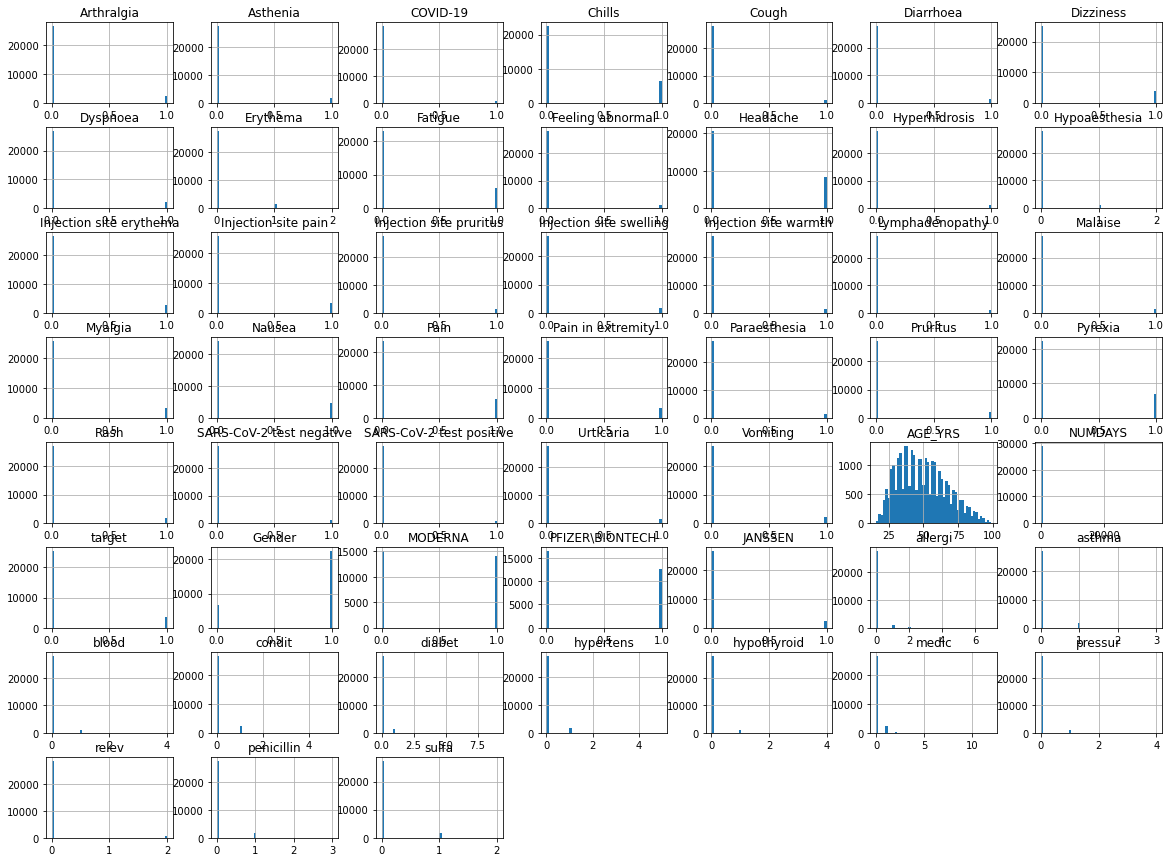

In [73]:
# Import Matplotlib for plotting
import matplotlib.pyplot as plt
%matplotlib inline

df_merge.hist(bins=50, figsize=(20,15));

In [74]:
# Variable Correlations with target
df_merge.corr()['target'].sort_values(ascending=False)

target                      1.000000
AGE_YRS                     0.338083
Dyspnoea                    0.269475
Asthenia                    0.147948
hypertens                   0.147573
SARS-CoV-2 test negative    0.146734
diabet                      0.142609
SARS-CoV-2 test positive    0.139795
COVID-19                    0.139074
Vomiting                    0.082831
Cough                       0.067850
hypothyroid                 0.053677
PFIZER\BIONTECH             0.037456
Malaise                     0.036731
Diarrhoea                   0.025644
Hypoaesthesia               0.018954
pressur                     0.017443
blood                       0.016703
penicillin                  0.016396
medic                       0.015218
Feeling abnormal            0.010334
MODERNA                     0.008076
condit                      0.001240
NUMDAYS                     0.000823
sulfa                      -0.003435
Hyperhidrosis              -0.003970
Paraesthesia               -0.007940
a

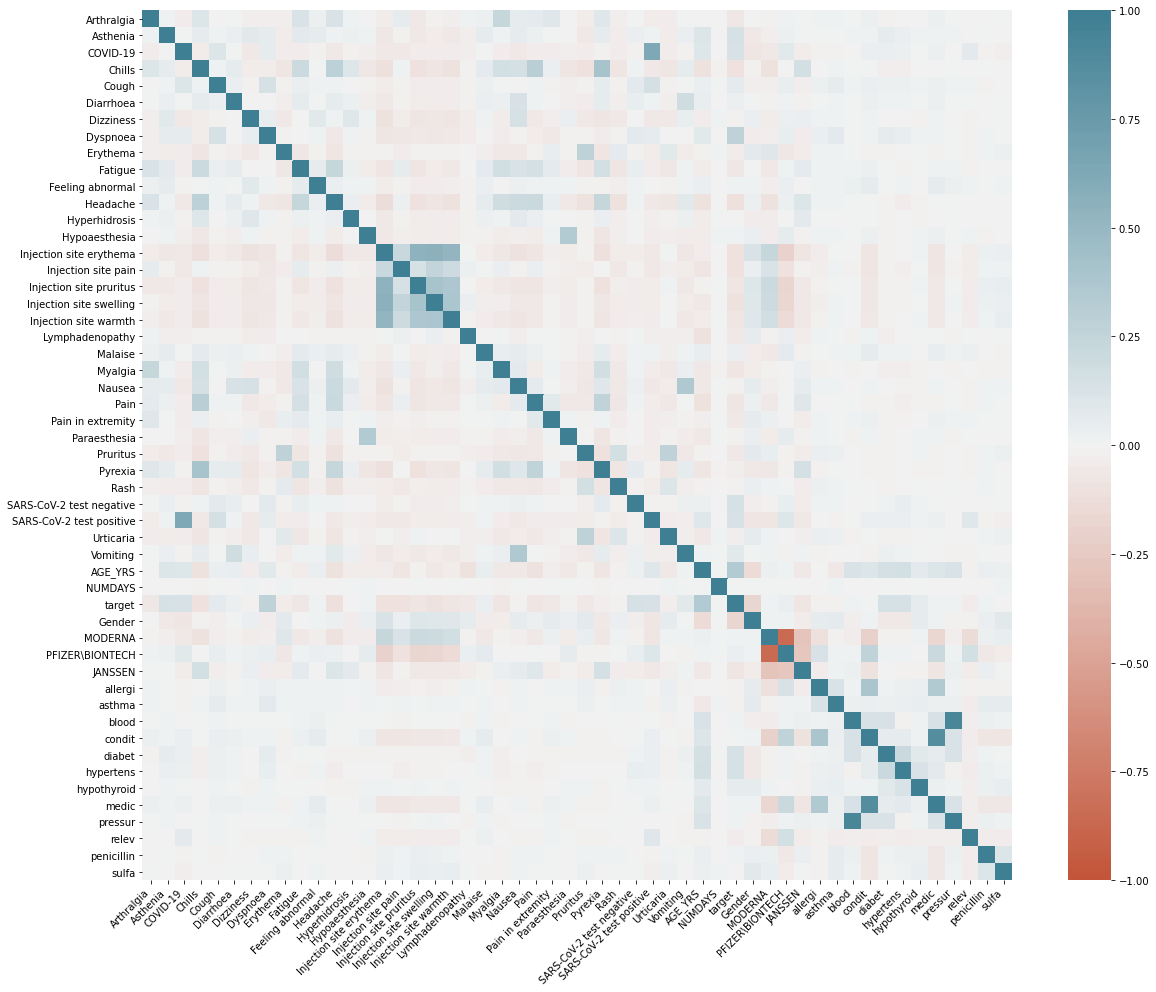

In [75]:
from seaborn import heatmap, diverging_palette

fig, ax = plt.subplots(figsize=(20, 16))

corr = df_merge.corr()
ax = heatmap(corr, vmin=-1, vmax=1, center=0, 
    cmap=diverging_palette(20, 220, n=200), square=True, annot=False)

ax.set_xticklabels( ax.get_xticklabels(),
    rotation=45, horizontalalignment='right');

## Classification Models

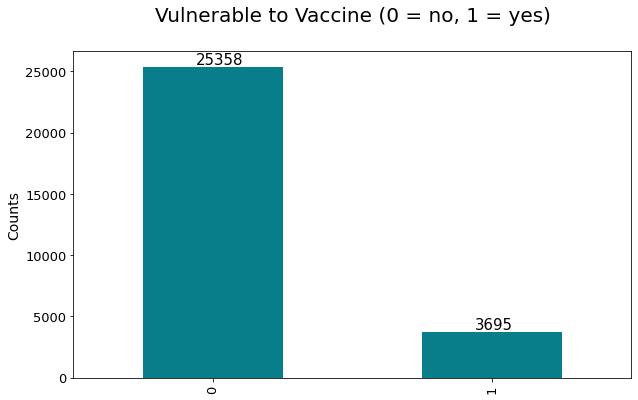

In [77]:
import matplotlib.pyplot as plt

# showing how are dataset is unbalanced
ax = df_merge['target'].value_counts().plot(kind='bar', figsize=(10, 6), fontsize=13, color='#087E8B')
ax.set_title('Vulnerable to Vaccine (0 = no, 1 = yes)', size=20, pad=30)
ax.set_ylabel('Counts', fontsize=14)

for i in ax.patches:
    ax.text(i.get_x() + 0.19, i.get_height() + 250, str(round(i.get_height(), 2)), fontsize=15)

### Classification with Unbalanced Dataset

In [78]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, precision_recall_curve, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, roc_auc_score, accuracy_score

#### Split Dataset into training and test set 

In [79]:
allData = df_merge
y = df_merge['target'] # 1D targer vector
X = df_merge.drop(labels='target', axis=1)

# Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 42)

# Scale the data
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#### Handling Imbalanced data with Synthetic Minority Oversampling TEchnique - SMOTE 

In [80]:
!pip install imbalanced-learn

from imblearn.over_sampling import SMOTE

smt = SMOTE(random_state=42)
X_train_SMOTE, y_train_SMOTE = smt.fit_resample(X_train, y_train)

print(f'''\nShape of X before SMOTE: {X_train.shape}
Shape of X after SMOTE: {X_train_SMOTE.shape}''')

print('\nBalance of positive and negative classes (%):')
y_train_SMOTE.value_counts(normalize=True) * 100


Shape of X before SMOTE: (23242, 51)
Shape of X after SMOTE: (40552, 51)

Balance of positive and negative classes (%):


1    50.0
0    50.0
Name: target, dtype: float64

#### Fucntion to print any classifier report

In [81]:
from sklearn.metrics import plot_confusion_matrix, roc_auc_score, accuracy_score
from sklearn.metrics import average_precision_score, balanced_accuracy_score, plot_precision_recall_curve

def print_report_classifiers(model, y_train_pred, y_test_pred, X_test=X_test, Y_test=y_test, Y_train=y_train,
                             auc=True, conf_train=True):
    
    print("\nTraining Accuracy: {0:0.4f}".format(accuracy_score(Y_train, y_train_pred)))
    print("Test Accuracy: {0:0.4f}".format(accuracy_score(Y_test, y_test_pred)))
    
    print("\nTest Confusion Matrix:")
    print(confusion_matrix(Y_test, y_test_pred))

    print(classification_report(Y_test, y_test_pred))
    
    if auc:
        if model in ["svm_rbf_clf"]:
            #print("ROC-AUC Score:",roc_auc_score(Y_test, model.decision_function(X_test)[:,1]))
            average_precision = average_precision_score(y_test, model.decision_function(X_test)[:,1])
        else:
            #print("ROC-AUC Score:",roc_auc_score(Y_test, model.predict_proba(X_test)[:,1]))
            average_precision = average_precision_score(y_test, model.predict_proba(X_test)[:,1])
        
        if conf_train:
            disp = plot_precision_recall_curve(model, X_test, y_test)   
            disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))
        print("Precision-Recall AUC: {:0.2f}".format(average_precision))
    
    print("Balanced accuaracy: {:0.2f}".format(balanced_accuracy_score(Y_test, y_test_pred)))
    
    #plot_roc_curve(model, Xtest, ytest)
    #plt.show()

### - Model: KNN

In [82]:
from sklearn.neighbors import KNeighborsClassifier

knnclf = KNeighborsClassifier()
knnclf.fit(X_train, y_train)

y_train_predicted = knnclf.predict(X_train)
y_test_predicted = knnclf.predict(X_test)

print_report_classifiers(knnclf, y_train_predicted, y_test_predicted, conf_train=False)


Training Accuracy: 0.9154
Test Accuracy: 0.8957

Test Confusion Matrix:
[[4914  168]
 [ 438  291]]
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      5082
           1       0.63      0.40      0.49       729

    accuracy                           0.90      5811
   macro avg       0.78      0.68      0.72      5811
weighted avg       0.88      0.90      0.89      5811

Precision-Recall AUC: 0.45
Balanced accuaracy: 0.68


#### KNN Hyperparameter Tuning

In [ ]:
%%time

#List Hyperparameters
leaf_size = [1,10,20,30,40,50]
n_neighbors = list(range(3,15,2))
metric = ['euclidean','manhattan'] 
p=[1,2]

#Convert to dictionary
hyperparameters = dict(n_neighbors=n_neighbors, p=p, metric = metric)

#Create new KNN object
knnclf2 = KNeighborsClassifier()

#Use GridSearch
clf = GridSearchCV(knnclf2, hyperparameters, cv=5, scoring='f1')

#Fit the model
best_model = clf.fit(X_train_SMOTE, y_train_SMOTE)

#Print The value of best Hyperparameters
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])
print('Best Metric:', best_model.best_estimator_.get_params()['metric'])
print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])


For hyperparameter tunning we will leave the cells with the code used to find the optimal parameters in the form of a raw cells (for the models where Hyperparameter tunning took more than a few minutes) and report the results.

Optimal Parameters for KNN:
* p: 1
* n_neighbors: 5
* Metric: manhattan
* leaf_size: 30

In [83]:
%%time
# knn optimal parameters with SMOTE
knnclffinal = KNeighborsClassifier(leaf_size=30, n_neighbors=5, 
                                   p=1, metric='manhattan')

knnclffinal.fit(X_train_SMOTE, y_train_SMOTE)

y_train_predicted = knnclffinal.predict(X_train_SMOTE)
y_test_predicted = knnclffinal.predict(X_test)

print_report_classifiers(knnclffinal, y_train_predicted, y_test_predicted, 
                         Y_train=y_train_SMOTE, conf_train=False)


Training Accuracy: 0.9346
Test Accuracy: 0.8246

Test Confusion Matrix:
[[4345  737]
 [ 282  447]]
              precision    recall  f1-score   support

           0       0.94      0.85      0.90      5082
           1       0.38      0.61      0.47       729

    accuracy                           0.82      5811
   macro avg       0.66      0.73      0.68      5811
weighted avg       0.87      0.82      0.84      5811

Precision-Recall AUC: 0.38
Balanced accuaracy: 0.73
Wall time: 2min 36s


In [84]:
%%time
# knn optimal parameters
knnclffinal = KNeighborsClassifier(leaf_size=30, n_neighbors=5, 
                                   p=1, metric='manhattan')

knnclffinal.fit(X_train, y_train)

y_train_predicted = knnclffinal.predict(X_train)
y_test_predicted = knnclffinal.predict(X_test)

print_report_classifiers(knnclffinal, y_train_predicted, 
                         y_test_predicted, conf_train=False)


Training Accuracy: 0.9190
Test Accuracy: 0.8997

Test Confusion Matrix:
[[4939  143]
 [ 440  289]]
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      5082
           1       0.67      0.40      0.50       729

    accuracy                           0.90      5811
   macro avg       0.79      0.68      0.72      5811
weighted avg       0.89      0.90      0.89      5811

Precision-Recall AUC: 0.46
Balanced accuaracy: 0.68
Wall time: 1min 2s


### - Model: Naive Bayes
#### Gaussian NB Hyperparameter Tuning with unbalance dataset

In [85]:
%%time
from sklearn.naive_bayes import GaussianNB

param_grid = {'var_smoothing': [1.0, 2.0, 3.0, 4.0]}

gnb = GaussianNB()

gnb = GridSearchCV(gnb, param_grid, scoring='recall', cv=10, verbose=1, n_jobs=-1)
gnb.fit(X_train, y_train)

params_optimal = gnb.best_params_

print("Best Score (accuracy): %f" % gnb.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
Best Score (accuracy): 0.603839
Optimal Hyperparameter Values:  {'var_smoothing': 1.0}
Wall time: 4.58 s


#### Gaussian NB optimal parameters

In [86]:
# Train the Optimal Guassian NB Model
gaussianNB_clf = GaussianNB(var_smoothing=1.0)

gaussianNB_clf.fit(X_train, y_train)
y_train_predicted = gaussianNB_clf.predict(X_train)
y_test_predicted = gaussianNB_clf.predict(X_test)

print_report_classifiers(gaussianNB_clf, y_train_predicted, y_test_predicted, 
                        auc=True, conf_train=False)


Training Accuracy: 0.8365
Test Accuracy: 0.8339

Test Confusion Matrix:
[[4372  710]
 [ 255  474]]
              precision    recall  f1-score   support

           0       0.94      0.86      0.90      5082
           1       0.40      0.65      0.50       729

    accuracy                           0.83      5811
   macro avg       0.67      0.76      0.70      5811
weighted avg       0.88      0.83      0.85      5811

Precision-Recall AUC: 0.45
Balanced accuaracy: 0.76


#### Bernoulli NB with unblanced dataset

In [87]:
%%time
from sklearn.naive_bayes import BernoulliNB

param_grid = {'alpha': [1, 2, 3, 4, 5, 6]}

bnb = BernoulliNB()

bnb = GridSearchCV(bnb, param_grid, scoring='recall', cv=10, verbose=1, n_jobs=-1)
bnb.fit(X_train, y_train)

params_optimal = bnb.best_params_

print("Best Score (accuracy): %f" % bnb.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
Best Score (accuracy): 0.480786
Optimal Hyperparameter Values:  {'alpha': 1}
Wall time: 908 ms


In [88]:
# Train the Optimal Bernoulli NB Model
bernoulliNB_clf = BernoulliNB(alpha=2)
bernoulliNB_clf.fit(X_train, y_train)

y_train_predicted = bernoulliNB_clf.predict(X_train)
y_test_predicted = bernoulliNB_clf.predict(X_test)

print_report_classifiers(bernoulliNB_clf, y_train_predicted, y_test_predicted, 
                        auc=True, conf_train=False)


Training Accuracy: 0.8865
Test Accuracy: 0.8881

Test Confusion Matrix:
[[4784  298]
 [ 352  377]]
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      5082
           1       0.56      0.52      0.54       729

    accuracy                           0.89      5811
   macro avg       0.74      0.73      0.74      5811
weighted avg       0.88      0.89      0.89      5811

Precision-Recall AUC: 0.54
Balanced accuaracy: 0.73


#### Gaussian NB with SMOTE

In [89]:
%%time
from sklearn.naive_bayes import GaussianNB

param_grid = {'var_smoothing': [10,100,1000,1001]}

gnb = GaussianNB()

gnb = GridSearchCV(gnb, param_grid, scoring='f1', cv=10, verbose=1, n_jobs=-1)
gnb.fit(X_train_SMOTE, y_train_SMOTE)

params_optimal = gnb.best_params_

print("Best Score (accuracy): %f" % gnb.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
Best Score (accuracy): 0.792028
Optimal Hyperparameter Values:  {'var_smoothing': 10}
Wall time: 1.28 s


In [90]:
# Train the Optimal Guassian NB Model
gaussianNB_clf = GaussianNB(var_smoothing=100)
gaussianNB_clf.fit(X_train_SMOTE, y_train_SMOTE)

y_train_predicted = gaussianNB_clf.predict(X_train_SMOTE)
y_test_predicted = gaussianNB_clf.predict(X_test)

print_report_classifiers(gaussianNB_clf, y_train_predicted, y_test_predicted, 
                        Y_train=y_train_SMOTE, auc=True, conf_train=False)


Training Accuracy: 0.7777
Test Accuracy: 0.7064

Test Confusion Matrix:
[[3503 1579]
 [ 127  602]]
              precision    recall  f1-score   support

           0       0.97      0.69      0.80      5082
           1       0.28      0.83      0.41       729

    accuracy                           0.71      5811
   macro avg       0.62      0.76      0.61      5811
weighted avg       0.88      0.71      0.76      5811

Precision-Recall AUC: 0.55
Balanced accuaracy: 0.76


#### Bernoulli NB with SMOTE

In [91]:
%%time
from sklearn.naive_bayes import BernoulliNB

param_grid = {'alpha': [15,16,17]}

bnb = BernoulliNB()

bnb = GridSearchCV(bnb, param_grid, scoring='f1', cv=10, verbose=1, n_jobs=-1)
bnb.fit(X_train_SMOTE, y_train_SMOTE)

params_optimal = bnb.best_params_

print("Best Score (accuracy): %f" % bnb.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal)

Fitting 10 folds for each of 3 candidates, totalling 30 fits
Best Score (accuracy): 0.778535
Optimal Hyperparameter Values:  {'alpha': 16}
Wall time: 915 ms


In [92]:
# Train the Optimal Bernoulli NB Model
bernoulliNB_clf = BernoulliNB(alpha=16)
bernoulliNB_clf.fit(X_train_SMOTE, y_train_SMOTE)

y_train_predicted = bernoulliNB_clf.predict(X_train_SMOTE)
y_test_predicted = bernoulliNB_clf.predict(X_test)

print_report_classifiers(bernoulliNB_clf, y_train_predicted, y_test_predicted, 
                        Y_train=y_train_SMOTE, auc=True, conf_train=False)


Training Accuracy: 0.7790
Test Accuracy: 0.7710

Test Confusion Matrix:
[[3926 1156]
 [ 175  554]]
              precision    recall  f1-score   support

           0       0.96      0.77      0.86      5082
           1       0.32      0.76      0.45       729

    accuracy                           0.77      5811
   macro avg       0.64      0.77      0.65      5811
weighted avg       0.88      0.77      0.80      5811

Precision-Recall AUC: 0.54
Balanced accuaracy: 0.77


### Model: Logistic Regression
#### LR Hyperparameter runing

In [93]:
%%time
from sklearn.linear_model import LogisticRegression

param_grid = {'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], 
              'tol': [1e-3, 1e-4], 'max_iter':[150, 200],
              'C': [0.1, 1, 5, 10], 'class_weight':[None, 'balanced']}

lg_reg = LogisticRegression(random_state=42)

lg_reg_cv = GridSearchCV(lg_reg, param_grid, scoring='recall', cv=5)
lg_reg_cv.fit(X_train, y_train)

params_optimal = lg_reg_cv.best_params_

print("Best Score (accuracy): %f" % lg_reg_cv.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal)

C:\Users\andre\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\andre\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\andre\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Best Score (accuracy): 0.771408
Optimal Hyperparameter Values:  {'C': 0.1, 'class_weight': 'balanced', 'max_iter': 150, 'solver': 'liblinear', 'tol': 0.001}
Wall time: 5min 19s


Optimal Parameters for LR:

* C: 0.1
* max_iter: 150
* solver: liblinear
* tol: 0.001
* class_weight: Balanced

In [94]:
%%time
from sklearn.linear_model import LogisticRegression
# Train the Optimal LR Model
lg_reg_clf = LogisticRegression(solver='liblinear', tol=0.001, 
                                max_iter= 150, C=0.1, class_weight='balanced')
lg_reg_clf.fit(X_train, y_train)

y_train_predicted = lg_reg_clf.predict(X_train)
y_test_predicted = lg_reg_clf.predict(X_test)

print_report_classifiers(lg_reg_clf, y_train_predicted, y_test_predicted, 
                        auc=True, conf_train=False)


Training Accuracy: 0.8023
Test Accuracy: 0.7992

Test Confusion Matrix:
[[4075 1007]
 [ 160  569]]
              precision    recall  f1-score   support

           0       0.96      0.80      0.87      5082
           1       0.36      0.78      0.49       729

    accuracy                           0.80      5811
   macro avg       0.66      0.79      0.68      5811
weighted avg       0.89      0.80      0.83      5811

Precision-Recall AUC: 0.60
Balanced accuaracy: 0.79
Wall time: 242 ms


#### LR hyperparameter tuning with SMOTE

In [95]:
%%time
from sklearn.linear_model import LogisticRegression

param_grid = {'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], 
              'tol': [1e-3, 1e-4], 'max_iter':[110,150],'C': [1,5,6]}

lg_reg = LogisticRegression(random_state=42)

lg_reg_cv = GridSearchCV(lg_reg, param_grid, scoring='recall', cv=5)
lg_reg_cv.fit(X_train_SMOTE, y_train_SMOTE)

params_optimal = lg_reg_cv.best_params_

print("Best Score (accuracy): %f" % lg_reg_cv.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal)

Best Score (accuracy): 0.798037
Optimal Hyperparameter Values:  {'C': 1, 'max_iter': 110, 'solver': 'liblinear', 'tol': 0.001}
Wall time: 2min 52s


Optimal Parameters for LS SMOTE:

* C: 1
* max_iter: 110
* solver: liblinear
* tol: 0.001

In [96]:
# Train the Optimal LR Model

lg_reg_clf = LogisticRegression(solver='liblinear', tol=0.001, 
                                max_iter= 110, C=1)
lg_reg_clf.fit(X_train_SMOTE, y_train_SMOTE)

y_train_predicted = lg_reg_clf.predict(X_train_SMOTE)
y_test_predicted = lg_reg_clf.predict(X_test)

print_report_classifiers(lg_reg_clf, y_train_predicted, y_test_predicted, 
                        Y_train=y_train_SMOTE, auc=True, conf_train=False)


Training Accuracy: 0.8052
Test Accuracy: 0.8002

Test Confusion Matrix:
[[4087  995]
 [ 166  563]]
              precision    recall  f1-score   support

           0       0.96      0.80      0.88      5082
           1       0.36      0.77      0.49       729

    accuracy                           0.80      5811
   macro avg       0.66      0.79      0.68      5811
weighted avg       0.89      0.80      0.83      5811

Precision-Recall AUC: 0.61
Balanced accuaracy: 0.79


### - Model: Support Vector Machine 
#### Implement LinearSVC with default values

In [97]:
from sklearn.svm import LinearSVC, SVC

# Implement Linear SVC with default paramenters with CLASS WEIGHT
linear_svc_clf = LinearSVC(random_state=42)
linear_svc_clf.fit(X_train, y_train)

# Prediction of training set
y_train_predicted = linear_svc_clf.predict(X_train)
# Prediction of test set
y_test_predicted = linear_svc_clf.predict(X_test)

print_report_classifiers(linear_svc_clf, y_train_predicted, y_test_predicted, 
                         auc=False, conf_train=False)



Training Accuracy: 0.9035
Test Accuracy: 0.9071

Test Confusion Matrix:
[[4998   84]
 [ 456  273]]
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      5082
           1       0.76      0.37      0.50       729

    accuracy                           0.91      5811
   macro avg       0.84      0.68      0.73      5811
weighted avg       0.90      0.91      0.89      5811

Balanced accuaracy: 0.68


C:\Users\andre\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


#### Hyperparameter tunning for LinearSVC

In [ ]:
%%time
# Hyperparameter tunning for the LinearSVC
param_grid = {'C': [1, 10, 100], 
              'max_iter':[1000, 2000, 3000],
              'tol': [0.001, 0.0001],
              'penalty': ['l1', 'l2'],
              'class_weight': [None, 'balanced']
              }

clf_svc = LinearSVC(loss="squared_hinge", random_state=42, dual=False)
clf_svc_cv = GridSearchCV(clf_svc, param_grid, scoring='recall', cv=5, verbose=1, n_jobs=-1)
clf_svc_cv.fit(X_train, y_train.ravel())

params_optimal_svc = clf_svc_cv.best_params_
print("Best Score (accuracy): %f" % clf_svc_cv.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal_svc)
print("\n")

Optimal Parameters for LinearSVC:

* C: 1
* max_iter: 1000
* tol: 0.001
* class_weight: balanced
* penalty: l1
* dual: False

#### LinearSVC with optimal values - imbalanced data

In [98]:
%%time

linear_svc_clf = LinearSVC(C=1, max_iter=1000, tol=0.001, 
                           loss="squared_hinge", random_state=42,
                           dual=False, class_weight='balanced', penalty='l1')

# train LienarSVC model
linear_svc_clf.fit(X_train, y_train)

y_train_predicted = linear_svc_clf.predict(X_train)
y_test_predicted = linear_svc_clf.predict(X_test)

print_report_classifiers(linear_svc_clf, y_train_predicted, 
                         y_test_predicted, auc=False, conf_train=False)


Training Accuracy: 0.8063
Test Accuracy: 0.8030

Test Confusion Matrix:
[[4102  980]
 [ 165  564]]
              precision    recall  f1-score   support

           0       0.96      0.81      0.88      5082
           1       0.37      0.77      0.50       729

    accuracy                           0.80      5811
   macro avg       0.66      0.79      0.69      5811
weighted avg       0.89      0.80      0.83      5811

Balanced accuaracy: 0.79
Wall time: 320 ms


#### LinearSVC optimal values - SMOTE

In [99]:
# Implement Linear SVC optimal parameters with SMOTE
linear_svc_clf = LinearSVC(C=1, max_iter=1000, tol=0.001, 
                           loss="squared_hinge", random_state=42,
                           dual=False, penalty='l1')

# train LienarSVC model
linear_svc_clf.fit(X_train_SMOTE, y_train_SMOTE)

y_train_predicted = linear_svc_clf.predict(X_train_SMOTE)
y_test_predicted = linear_svc_clf.predict(X_test)

print_report_classifiers(linear_svc_clf, y_train_predicted, 
                         y_test_predicted, Y_train=y_train_SMOTE,
                         auc=False, conf_train=False)


Training Accuracy: 0.8053
Test Accuracy: 0.8021

Test Confusion Matrix:
[[4101  981]
 [ 169  560]]
              precision    recall  f1-score   support

           0       0.96      0.81      0.88      5082
           1       0.36      0.77      0.49       729

    accuracy                           0.80      5811
   macro avg       0.66      0.79      0.69      5811
weighted avg       0.89      0.80      0.83      5811

Balanced accuaracy: 0.79


LinearSVC seems to be fitting the data set. There is barely no difference in the performance in the train set and test set. However the results show that the model does a better job classifying class 0 (patients who didn't or enconuter high risk reactions from the vaccine) due to the dataset being unbalanced.

Let's see how the dataset performs when we use **polynomial kernels with SVM**:

#### Hyperparameter tunning for polynomial SVM - Finding Optimal degree

In [ ]:
%%time

# Split data set into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 42, stratify=y)

# Split Training data into Traing and Validation Fold
X_train_fold, X_val_fold, y_train_fold, y_val_fold = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

# Scale the train and test set
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)

degreeList = [1, 2, 3, 5]

accuracy_train, accuracy_val = [], []

for degree in degreeList:
    
    model = SVC(C=10, kernel='poly', degree=degree, gamma='auto')
    
    model.fit(X_train_fold, y_train_fold)
       
    # Make prediction 
    y_train_predicted = model.predict(X_train_fold)
    y_val_predicted = model.predict(X_val_fold)
    
    accuracy_train.append(model.score(X_train_fold, y_train_fold))
    accuracy_val.append(model.score(X_val_fold, y_val_fold))
    

plt.figure(figsize=(10, 6))   
plt.plot(degreeList, accuracy_val, "ro-", alpha=1.0, linewidth=1.0, label="Validation Accuracy")
plt.plot(degreeList, accuracy_train, "bo-", alpha=1.0, linewidth=1.0, label="Train Accuracy")  

plt.legend(loc="best", fontsize=14) 
plt.xlabel("Degree")
plt.ylabel("Accuracy")
plt.title("Accuracy for Varying Degree")
plt.show()


# Find the value of degree that gives max validation accuracy
j = 0
max_val_accuracy = accuracy_val[j]
optimal_degree = 1

for i in degreeList:
    if(accuracy_val[j] > max_val_accuracy):
        max_val_accuracy = accuracy_val[j]
        optimal_degree = i
    j +=1
    
print("Optimal Degree: ", optimal_degree)
print("\n")

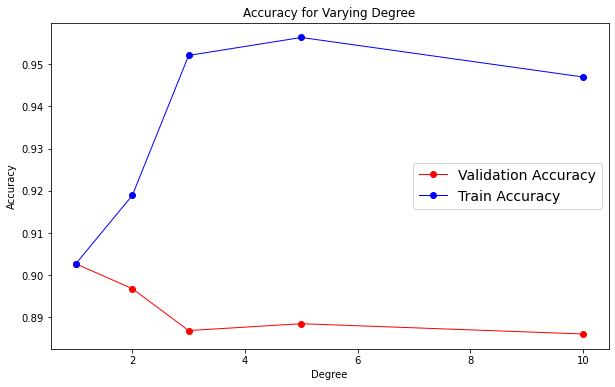
Optimal Degree: 1


### - Model: Multilayer Perceptron
#### Hyperparameter tuning MLP

In [ ]:
%%time

from sklearn.neural_network import MLPClassifier

param_grid = {'hidden_layer_sizes': [(5,), (10,), (50,), (100,), (150,)],
               'activation':['logistic', 'relu', 'tanh'],
               'alpha': (0.1, 0.01, 0.001),
               'tol': (0.001, 0.0001),
               'learning_rate_init':[0.1, 0.01, 0.001],
               'learning_rate': ['adaptive', 'constant']}

clf_mlp = MLPClassifier(solver='adam', early_stopping=False)

clf_mlp_cv = GridSearchCV(clf_mlp, param_grid, scoring='f1', cv=5, verbose=1, n_jobs=-1)
clf_mlp_cv.fit(X_train, y_train)


params_optimal_mlp = clf_mlp_cv.best_params_

print("Best Score (accuracy): %f" % clf_mlp_cv.best_score_)

print("Optimal Hyperparameter Values: ", params_optimal_mlp)

Wall time: 1h 28min 50s

For MLP we decided to use solver='adam' due to recommendations by sklearn documentation regarding the size of the dataset.
Early_stopping = True was also used to aovid overtraining and overfitting on the training set.

Optimal Parameters for LinearSVC:

* hidden_layer_sizes: 50
* activation: logistic
* alpha: 0.1
* tol: 0.0001
* learning_rate_init: 0.01
* learning_rate: adaptive

#### MLP with optimal parameters

In [100]:
%%time

from sklearn.neural_network import MLPClassifier


mlp_clf = MLPClassifier(random_state=42, hidden_layer_sizes=(50,), alpha=0.1, solver='adam',
                      learning_rate='adaptive', activation='logistic', verbose=False,
                      learning_rate_init=0.01, tol=0.0001, early_stopping=True)

mlp_clf.fit(X_train, y_train)


print("No. of Iterations:", mlp_clf.n_iter_ )

y_train_predicted = mlp_clf.predict(X_train)
y_test_predicted = mlp_clf.predict(X_test)

print_report_classifiers(mlp_clf, y_train_predicted, y_test_predicted,
                        auc=True, conf_train=False)

No. of Iterations: 24

Training Accuracy: 0.9074
Test Accuracy: 0.9145

Test Confusion Matrix:
[[5004   78]
 [ 419  310]]
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      5082
           1       0.80      0.43      0.56       729

    accuracy                           0.91      5811
   macro avg       0.86      0.70      0.75      5811
weighted avg       0.91      0.91      0.90      5811

Precision-Recall AUC: 0.64
Balanced accuaracy: 0.70
Wall time: 2.64 s


#### MLP optimal parameters with SMOTE 

No. of Iterations: 54

Training Accuracy: 0.8470
Test Accuracy: 0.8143

Test Confusion Matrix:
[[4180  902]
 [ 177  552]]
              precision    recall  f1-score   support

           0       0.96      0.82      0.89      5082
           1       0.38      0.76      0.51       729

    accuracy                           0.81      5811
   macro avg       0.67      0.79      0.70      5811
weighted avg       0.89      0.81      0.84      5811

Precision-Recall AUC: 0.61
Balanced accuaracy: 0.79


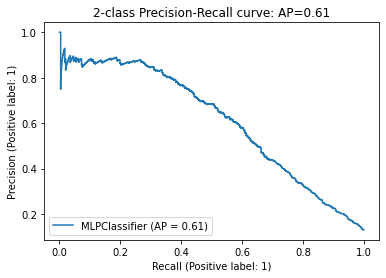

In [101]:
from sklearn.metrics import precision_recall_curve, auc

mlp_clf_SMOTE = MLPClassifier(random_state=42, hidden_layer_sizes=(50,), alpha=0.1, solver='adam',
                      learning_rate='adaptive', activation='logistic', verbose=False,
                      learning_rate_init=0.01, tol=0.0001, early_stopping=True)

mlp_clf_SMOTE.fit(X_train_SMOTE, y_train_SMOTE);

print("No. of Iterations:", mlp_clf_SMOTE.n_iter_ )

# perdiction on training set
y_train_predicted = mlp_clf_SMOTE.predict(X_train_SMOTE)
# predictions on test set
y_test_predicted = mlp_clf_SMOTE.predict(X_test)

print_report_classifiers(mlp_clf_SMOTE, y_train_predicted, y_test_predicted, 
                         Y_train =y_train_SMOTE, auc=True, conf_train=True)


In [102]:
from sklearn.model_selection import cross_val_score

# validating our model with train set without SMOTE using cross-val
# to make sure the model is not overfitting the dataset. We use f1 score 
# 
from imblearn.pipeline import make_pipeline

def evaluate_model(X_train, y_train, model):
    
    model.fit(X_train, y_train)
    test_pred = model.predict(X_test)
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    scores_ba = cross_val_score(model, X_train, y_train, cv=3, scoring="balanced_accuracy")
    diff = scores.mean() - f1_score(y_test, test_pred)

    
    print(f"Training Accuracy:{model.score(X_train, y_train)}")
    print(f"Testing Accuracy: {model.score(X_test, y_test)}")
    
    print(f"\nTest F1-score: {f1_score(y_test, test_pred)}")
    print(f"Cross-Val F1-score: {scores.mean()} +/- {scores.std()}")
    print(f"\nTest Balance accuracy: {balanced_accuracy_score(y_test, test_pred)}")
    print(f"Cross-Val Balance accuracy: {scores_ba.mean()} +/- {scores_ba.std()}")
    
pipeline = make_pipeline(smt, mlp_clf_SMOTE)
evaluate_model(X_train, y_train, pipeline)


Training Accuracy:0.8345667326391877
Testing Accuracy: 0.814317673378076

Test F1-score: 0.5057260650480989
Cross-Val F1-score: 0.505379471856166 +/- 0.01201256964873245

Test Balance accuracy: 0.7898562343006788
Cross-Val Balance accuracy: 0.7665827330320774 +/- 0.011037901793746304


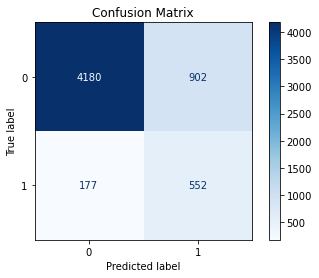

In [103]:
disp = plot_confusion_matrix(mlp_clf_SMOTE, X_test, y_test, cmap=plt.cm.Blues)
disp.ax_.set_title('Confusion Matrix')
plt.show()

### - Model: Random Forest

In [104]:
%%time
from sklearn.ensemble import RandomForestClassifier

rfclf = RandomForestClassifier(random_state=42)
rfclf.fit(X_train_SMOTE, y_train_SMOTE)

y_train_predicted = rfclf.predict(X_train_SMOTE)
y_test_predicted = rfclf.predict(X_test)

print_report_classifiers(rfclf, y_train_predicted, y_test_predicted,
                         Y_train=y_train_SMOTE, auc=True, conf_train=False)


Training Accuracy: 0.9984
Test Accuracy: 0.8935

Test Confusion Matrix:
[[4819  263]
 [ 356  373]]
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      5082
           1       0.59      0.51      0.55       729

    accuracy                           0.89      5811
   macro avg       0.76      0.73      0.74      5811
weighted avg       0.89      0.89      0.89      5811

Precision-Recall AUC: 0.58
Balanced accuaracy: 0.73
Wall time: 7.98 s


#### Random Forest Hyperparameter Tuning

In [ ]:
#List Hyperparameters
bootstrap = [True, False]
max_depth = [20, 50, 100, None]
max_features = ['auto', 'sqrt']
min_samples_leaf = [1, 4]
min_samples_split = [2, 10]
n_estimators = [1000, 2000]

`r
#Convert to dictionary
hyperparameters = dict(bootstrap=bootstrap, 
                       max_depth=max_depth, max_features = max_features,
                      min_samples_leaf = min_samples_leaf, min_samples_split = min_samples_split,
                      n_estimators = n_estimators)

#Create new RF object
rfclf2 = RandomForestClassifier(random_state=42)

#Use GridSearch
clf = GridSearchCV(rfclf2, hyperparameters, cv=10)

#Fit the model
best_model = clf.fit(X_train_SMOTE, y_train_SMOTE)

#Print The value of best Hyperparameters
print('Best bootstrap:', best_model.best_estimator_.get_params()['bootstrap'])
print('Best max_depth:', best_model.best_estimator_.get_params()['max_depth'])
print('Best max_features:', best_model.best_estimator_.get_params()['max_features'])
print('Best min_samples_leaf:', best_model.best_estimator_.get_params()['min_samples_leaf'])
print('Best min_samples_split:', best_model.best_estimator_.get_params()['min_samples_split'])
print('n_estimators:', best_model.best_estimator_.get_params()['n_estimators'])


Optimal Parameters for Random Forest (SMOTE):

* bootstrap: False
* max_depth: 50
* max_features: auto 
* min_samples_leaf: 1
* min_samples_split: 10
* n_estimators: 2000

#### RF optimal parameter with SMOTE  

In [105]:
%%time

rfclffinal = RandomForestClassifier(random_state=42, bootstrap=False, max_depth = 50, 
                                    max_features = 'auto', min_samples_leaf = 1, 
                                    min_samples_split = 10, n_estimators = 2000)

rfclffinal.fit(X_train_SMOTE, y_train_SMOTE)

y_train_predicted = rfclffinal.predict(X_train_SMOTE)
y_test_predicted = rfclffinal.predict(X_test)

print_report_classifiers(rfclffinal, y_train_predicted, y_test_predicted,
                         Y_train=y_train_SMOTE, auc=True, conf_train=False)


Training Accuracy: 0.9873
Test Accuracy: 0.8993

Test Confusion Matrix:
[[4841  241]
 [ 344  385]]
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      5082
           1       0.62      0.53      0.57       729

    accuracy                           0.90      5811
   macro avg       0.77      0.74      0.76      5811
weighted avg       0.89      0.90      0.90      5811

Precision-Recall AUC: 0.60
Balanced accuaracy: 0.74
Wall time: 3min 39s


#### RF optimal parameter imbalaced data

In [106]:
%%time
rfclffinal = RandomForestClassifier(random_state=42, bootstrap=False,max_depth = 50, 
                                    max_features = 'auto', min_samples_leaf = 1, 
                                    min_samples_split = 10, n_estimators = 2000,
                                   class_weight='balanced')

rfclffinal.fit(X_train, y_train)

y_train_predicted = rfclffinal.predict(X_train)
y_test_predicted = rfclffinal.predict(X_test)

print_report_classifiers(rfclffinal, y_train_predicted, 
                         y_test_predicted, auc=True, conf_train=False)


Training Accuracy: 0.9724
Test Accuracy: 0.8887

Test Confusion Matrix:
[[4706  376]
 [ 271  458]]
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      5082
           1       0.55      0.63      0.59       729

    accuracy                           0.89      5811
   macro avg       0.75      0.78      0.76      5811
weighted avg       0.90      0.89      0.89      5811

Precision-Recall AUC: 0.62
Balanced accuaracy: 0.78
Wall time: 1min 38s


#### RF optimal parameters with boostrap = True 

We decided to use boostrap to help with the imbalanced distribution of classes of our dataset.

In [107]:
rfclffinal = RandomForestClassifier(random_state=42, bootstrap=True, max_depth = 50, 
                                    max_features = 'auto', min_samples_leaf = 1, 
                                    min_samples_split = 10, n_estimators = 2000)

rfclffinal.fit(X_train_SMOTE, y_train_SMOTE)

y_train_predicted = rfclffinal.predict(X_train_SMOTE)
y_test_predicted = rfclffinal.predict(X_test)

print_report_classifiers(rfclffinal, y_train_predicted, y_test_predicted,
                         Y_train=y_train_SMOTE, auc=True, conf_train=False)


Training Accuracy: 0.9739
Test Accuracy: 0.8981

Test Confusion Matrix:
[[4814  268]
 [ 324  405]]
              precision    recall  f1-score   support

           0       0.94      0.95      0.94      5082
           1       0.60      0.56      0.58       729

    accuracy                           0.90      5811
   macro avg       0.77      0.75      0.76      5811
weighted avg       0.89      0.90      0.90      5811

Precision-Recall AUC: 0.62
Balanced accuaracy: 0.75


In [108]:
%%time
rfclffinal = RandomForestClassifier(random_state=42, bootstrap=True, max_depth = 50, 
                                    max_features = 'auto', min_samples_leaf = 1, 
                                    min_samples_split = 10, n_estimators = 2000,
                                   class_weight='balanced')

rfclffinal.fit(X_train, y_train)

y_train_predicted = rfclffinal.predict(X_train)
y_test_predicted = rfclffinal.predict(X_test)

print_report_classifiers(rfclffinal, y_train_predicted, 
                         y_test_predicted, auc=True, conf_train=False)


Training Accuracy: 0.9639
Test Accuracy: 0.9007

Test Confusion Matrix:
[[4790  292]
 [ 285  444]]
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      5082
           1       0.60      0.61      0.61       729

    accuracy                           0.90      5811
   macro avg       0.77      0.78      0.77      5811
weighted avg       0.90      0.90      0.90      5811

Precision-Recall AUC: 0.64
Balanced accuaracy: 0.78
Wall time: 1min 8s


Feature: 0, Score: 0.01072
Feature: 1, Score: 0.01932
Feature: 2, Score: 0.00520
Feature: 3, Score: 0.02128
Feature: 4, Score: 0.00782
Feature: 5, Score: 0.00759
Feature: 6, Score: 0.01451
Feature: 7, Score: 0.07585
Feature: 8, Score: 0.01054
Feature: 9, Score: 0.01570
Feature: 10, Score: 0.00662
Feature: 11, Score: 0.02366
Feature: 12, Score: 0.00666
Feature: 13, Score: 0.00947
Feature: 14, Score: 0.02455
Feature: 15, Score: 0.02008
Feature: 16, Score: 0.01218
Feature: 17, Score: 0.00849
Feature: 18, Score: 0.00593
Feature: 19, Score: 0.00732
Feature: 20, Score: 0.00818
Feature: 21, Score: 0.01483
Feature: 22, Score: 0.01281
Feature: 23, Score: 0.01410
Feature: 24, Score: 0.01220
Feature: 25, Score: 0.00897
Feature: 26, Score: 0.01283
Feature: 27, Score: 0.01408
Feature: 28, Score: 0.01224
Feature: 29, Score: 0.02054
Feature: 30, Score: 0.00690
Feature: 31, Score: 0.00896
Feature: 32, Score: 0.01416
Feature: 33, Score: 0.27300
Feature: 34, Score: 0.08124
Feature: 35, Score: 0.03576
Fe

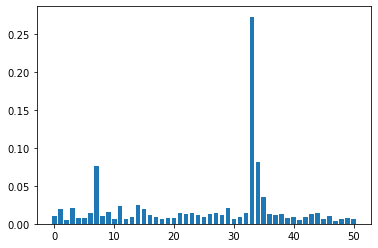

Wall time: 731 ms


In [109]:
%%time
from matplotlib import pyplot

# get feature importance from RF
importance = rfclffinal.feature_importances_

# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

Feature 7, 33 and Feature 34 are most important, these are age and numdays in hospital. However some symptoms are still important.

In [110]:
df_merge.columns

Index(['Arthralgia', 'Asthenia', 'COVID-19', 'Chills', 'Cough', 'Diarrhoea',
       'Dizziness', 'Dyspnoea', 'Erythema', 'Fatigue', 'Feeling abnormal',
       'Headache', 'Hyperhidrosis', 'Hypoaesthesia', 'Injection site erythema',
       'Injection site pain', 'Injection site pruritus',
       'Injection site swelling', 'Injection site warmth', 'Lymphadenopathy',
       'Malaise', 'Myalgia', 'Nausea', 'Pain', 'Pain in extremity',
       'Paraesthesia', 'Pruritus', 'Pyrexia', 'Rash',
       'SARS-CoV-2 test negative', 'SARS-CoV-2 test positive', 'Urticaria',
       'Vomiting', 'AGE_YRS', 'NUMDAYS', 'target', 'Gender', 'MODERNA',
       'PFIZER\BIONTECH', 'JANSSEN', 'allergi', 'asthma', 'blood', 'condit',
       'diabet', 'hypertens', 'hypothyroid', 'medic', 'pressur', 'relev',
       'penicillin', 'sulfa'],
      dtype='object')

### Model: Gradient Boosting
#### GB with unbalanced dataset

Optimal Parameters for GB with unbalanced dataset f1:

* learning_rate: 0.1
* max_depth: 8
* min_samples_leaf: 30
* min_samples_split: 2
* n_estimators: 300

In [111]:
%%time
from sklearn.ensemble import GradientBoostingClassifier

# Train the Optimal GB Model
grad_boost_clf = GradientBoostingClassifier(random_state=42, n_estimators=300, 
                                        learning_rate=0.1, max_depth=8,
                                       min_samples_leaf=30, min_samples_split=2)

grad_boost_clf.fit(X_train, y_train)

y_train_predicted = grad_boost_clf.predict(X_train)
y_test_predicted = grad_boost_clf.predict(X_test)

print_report_classifiers(grad_boost_clf, y_train_predicted, y_test_predicted, 
                        auc=True, conf_train=False)


Training Accuracy: 0.9449
Test Accuracy: 0.9081

Test Confusion Matrix:
[[4919  163]
 [ 371  358]]
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      5082
           1       0.69      0.49      0.57       729

    accuracy                           0.91      5811
   macro avg       0.81      0.73      0.76      5811
weighted avg       0.90      0.91      0.90      5811

Precision-Recall AUC: 0.63
Balanced accuaracy: 0.73
Wall time: 26.6 s


#### GB with SMOTE

In [112]:
grad_boost_clf = GradientBoostingClassifier(random_state=42, n_estimators=100, 
                                        learning_rate=0.1, max_depth=8,
                                       min_samples_leaf=30, min_samples_split=2)

grad_boost_clf.fit(X_train_SMOTE, y_train_SMOTE)

y_train_predicted = grad_boost_clf.predict(X_train_SMOTE)
y_test_predicted = grad_boost_clf.predict(X_test)

print_report_classifiers(grad_boost_clf, y_train_predicted, y_test_predicted, 
                        Y_train=y_train_SMOTE, auc=True, conf_train=False)


Training Accuracy: 0.9442
Test Accuracy: 0.9026

Test Confusion Matrix:
[[4831  251]
 [ 315  414]]
              precision    recall  f1-score   support

           0       0.94      0.95      0.94      5082
           1       0.62      0.57      0.59       729

    accuracy                           0.90      5811
   macro avg       0.78      0.76      0.77      5811
weighted avg       0.90      0.90      0.90      5811

Precision-Recall AUC: 0.64
Balanced accuaracy: 0.76


### - Model: Easy ensemble 
##### Default Values

In [113]:
%%time
from imblearn.ensemble import EasyEnsembleClassifier

# define model
easy_ensem = EasyEnsembleClassifier(n_estimators=100)

easy_ensem.fit(X_train, y_train)

y_train_predicted = easy_ensem.predict(X_train)
y_test_predicted = easy_ensem.predict(X_test)

print_report_classifiers(easy_ensem, y_train_predicted, 
                         y_test_predicted, auc=True, conf_train=False)


Training Accuracy: 0.8193
Test Accuracy: 0.8126

Test Confusion Matrix:
[[4162  920]
 [ 169  560]]
              precision    recall  f1-score   support

           0       0.96      0.82      0.88      5082
           1       0.38      0.77      0.51       729

    accuracy                           0.81      5811
   macro avg       0.67      0.79      0.70      5811
weighted avg       0.89      0.81      0.84      5811

Precision-Recall AUC: 0.62
Balanced accuaracy: 0.79
Wall time: 1min 39s


### - Model: AdaBoost 
#### AdaBoost Imbalanced data

In [114]:
from sklearn.ensemble import AdaBoostClassifier

adaboost_clf = AdaBoostClassifier(n_estimators=100, random_state=42)
adaboost_clf.fit(X_train, y_train)

y_train_predicted = adaboost_clf.predict(X_train)
y_test_predicted = adaboost_clf.predict(X_test)

print_report_classifiers(adaboost_clf, y_train_predicted, 
                         y_test_predicted, auc=True, conf_train=False)


Training Accuracy: 0.9078
Test Accuracy: 0.9093

Test Confusion Matrix:
[[4964  118]
 [ 409  320]]
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      5082
           1       0.73      0.44      0.55       729

    accuracy                           0.91      5811
   macro avg       0.83      0.71      0.75      5811
weighted avg       0.90      0.91      0.90      5811

Precision-Recall AUC: 0.62
Balanced accuaracy: 0.71


#### AdaBoost SMOTE

In [115]:
from sklearn.ensemble import AdaBoostClassifier

adaboost_clf = AdaBoostClassifier(n_estimators=100, random_state=42)

adaboost_clf.fit(X_train_SMOTE, y_train_SMOTE)

y_train_predicted = adaboost_clf.predict(X_train_SMOTE)
y_test_predicted = adaboost_clf.predict(X_test)

print_report_classifiers(adaboost_clf, y_train_predicted, y_test_predicted,
                         Y_train=y_train_SMOTE, auc=True, conf_train=False)


Training Accuracy: 0.9027
Test Accuracy: 0.8720

Test Confusion Matrix:
[[4598  484]
 [ 260  469]]
              precision    recall  f1-score   support

           0       0.95      0.90      0.93      5082
           1       0.49      0.64      0.56       729

    accuracy                           0.87      5811
   macro avg       0.72      0.77      0.74      5811
weighted avg       0.89      0.87      0.88      5811

Precision-Recall AUC: 0.61
Balanced accuaracy: 0.77


## Clustering

In [116]:
# let's see data again

# include only patients from the final clean data set 
cluster_data_withID = symptoms_data[symptoms_data['VAERS_ID'].isin(list(patients_VAERS_ID))]

# Drop "VAERS_ID" to perform clustering
cluster_data = cluster_data_withID.drop('VAERS_ID', 1)
cluster_data

,Arthralgia,Asthenia,COVID-19,Chills,Cough,Diarrhoea,Dizziness,Dyspnoea,Erythema,Fatigue,...,Pain,Pain in extremity,Paraesthesia,Pruritus,Pyrexia,Rash,SARS-CoV-2 test negative,SARS-CoV-2 test positive,Urticaria,Vomiting
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31497,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31498,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
31499,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,1,0
31500,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [117]:
import numpy as np
import pandas as pd
import seaborn as sns 
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score

In [118]:
def print_interpret_clusters(predicted_labels, df):
    
    # Number of patients in each cluster
    unique_elements, counts_elements = np.unique(predicted_labels, return_counts = True)
    print(np.asarray((unique_elements, counts_elements)))

    # interpret clusters 
    interpret_data = df.copy()
    interpret_data['cluster_labels'] = predicted_labels

    # compute the mean of each symptom for each cluster
    df_mean = (interpret_data.groupby('cluster_labels').mean())

    results = pd.DataFrame(columns=['Variable', 'Var'])
    for column in df_mean.columns[1:]:
        results.loc[len(results), :] = [column, np.var(df_mean[column])]

    # select the 10 most recurrent symptoms across all clusters
    selected_columns = list(results.sort_values('Var', ascending=False,).head(10).Variable.values) + ['cluster_labels']
    # plot the mean of the 10 most recurrent symtpoms 
    tidy = interpret_data[selected_columns].melt(id_vars='cluster_labels')
    sns.barplot(x='cluster_labels', y='value', hue='variable', data=tidy)

### - Model: K-Means++ Clustering

k=2 DB Score: 2.61
k=3 DB Score: 2.40
k=4 DB Score: 2.44
k=5 DB Score: 2.36
k=6 DB Score: 2.41
k=7 DB Score: 2.36
k=8 DB Score: 2.43
k=9 DB Score: 2.42
k=10 DB Score: 2.39
k=11 DB Score: 2.29
k=12 DB Score: 2.25
k=13 DB Score: 2.19


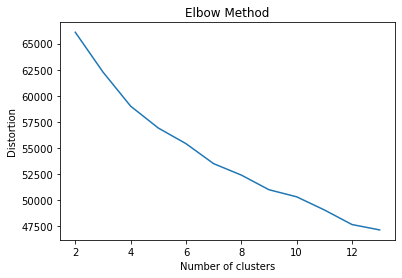

In [119]:
# elbow method to determine number of clusters
wcss = []
for i in range(2, 14):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    pred_cl = kmeans.fit_predict(cluster_data)
    print('k={} DB Score: {:.02f}'.format(i, davies_bouldin_score(cluster_data, pred_cl)))
    wcss.append(kmeans.inertia_)
    
plt.plot(range(2, 14), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [120]:
from sklearn.metrics import davies_bouldin_score

# categorize data using optimum number of clusters: 5
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10, random_state=42)
pred_y_kmeans = kmeans.fit_predict(cluster_data)

# Silhouette Score
print('Silhoutte Score: {}\n'.format(silhouette_score(cluster_data, pred_y_kmeans)))
print('DB Score: {}\n'.format(davies_bouldin_score(cluster_data, pred_y_kmeans)))
unique_elements, counts_elements = np.unique(pred_y_kmeans, return_counts = True)
print(np.asarray((unique_elements, counts_elements)))

Silhoutte Score: 0.12274732447685241

DB Score: 2.355321742778679

[[    0     1     2     3     4]
 [13332  4893  2691  3813  4324]]


#### Interpret Clusters for KMeans++ k = 5

[[    0     1     2     3     4]
 [13332  4893  2691  3813  4324]]


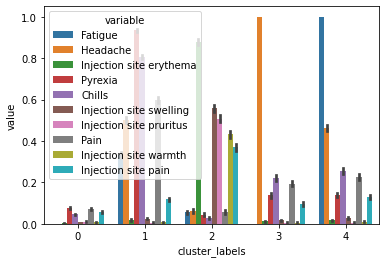

In [127]:
print_interpret_clusters(pred_y_kmeans, cluster_data)

### Visualizing Clusters

In [ ]:
%%time 
# visualizing clusters with T-SNE: used for high-dimensional data like ours
# visualizing clusters with T-SNE: used for high-dimensional data like ours

from sklearn.manifold import TSNE
from matplotlib.animation import FuncAnimation

def prepare_tsne(n_components, data, kmeans_labels):
    names = ['x', 'y', 'z']
    matrix = TSNE(n_components=n_components).fit_transform(data)
    df_matrix = pd.DataFrame(matrix)
    df_matrix.rename({i:names[i] for i in range(n_components)}, axis=1, inplace=True)
    df_matrix['labels'] = kmeans_labels
    return df_matrix
    
def plot_animation(df, label_column, name):
    def update(num):
        ax.view_init(200, num)

    N=360
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(tsne_3d_df['x'], tsne_3d_df['y'], tsne_3d_df['z'], c=tsne_3d_df[label_column],
               s=6, depthshade=True, cmap='Paired')
    ax.set_zlim(-15, 25)
    ax.set_xlim(-20, 20)
    plt.tight_layout()
    ani = animation.FuncAnimation(fig, update, N, blit=False, interval=50)
    ani.save('{}.gif'.format(name), writer='imagemagick')
    plt.show()
    
tsne_3d_df = prepare_tsne(3, cluster_data, pred_y_kmeans)
plot_animation(tsne_3d_df, 'labels', 'Kmeans')
# tfne_3d_df

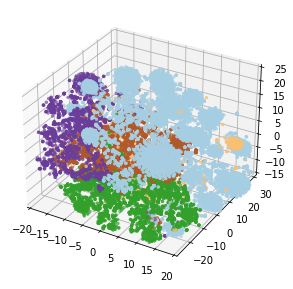

In [128]:
# interpret clusters 
interpret_data = cluster_data.copy()
interpret_data['cluster_labels'] = pred_y_kmeans

# How common is each cluster, and which one yields to more deaths?

# Counts of each cluster
interpret_data['cluster_labels'].value_counts(ascending = False)

0    13332
1     4893
4     4324
3     3813
2     2691
Name: cluster_labels, dtype: int64

In [129]:
# Which one represents more deaths/life threaths/hospital visits?
symptoms_data2 = cluster_data_withID.copy()
symptoms_data2['cluster_labels'] = pred_y_kmeans
cluster_target_data = symptoms_data2.merge(df_all[['VAERS_ID','target', 'AGE_YRS']], on='VAERS_ID')

summary = cluster_target_data.groupby(['cluster_labels'])['target'].sum().rename("target_count")
# percentage of each cluster at high-risk 
pcts = (summary / interpret_data['cluster_labels'].value_counts().sort_index())*100
pcts

cluster_labels
0    19.074407
1     6.683017
2     1.077666
3     9.834776
4     9.736355
dtype: float64

In [130]:
# In what cluster are the high-risk patients located?
# percentage of all hih-risk patients per cluster 
pcts = (summary / summary.sum())*100
pcts

cluster_labels
0    68.822733
1     8.849797
2     0.784844
3    10.148850
4    11.393775
Name: target_count, dtype: float64

#### Interpret Clusters for KMeans++ k = 3

Silhoutte Score: 0.129
DB Score: 2.396

[[    0     1     2]
 [ 9589  2797 16667]]


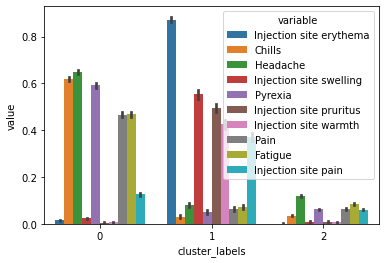

In [131]:
# categorize data using KMeans++ k = 3
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=42)
pred_y_kmeans3 = kmeans.fit_predict(cluster_data)

# Silhouette Score
print('Silhoutte Score: {:.3f}'.format(silhouette_score(cluster_data, pred_y_kmeans3)))
print('DB Score: {:.3f}\n'.format(davies_bouldin_score(cluster_data, pred_y_kmeans3)))

print_interpret_clusters(pred_y_kmeans3, cluster_data)

* [9589] Cluster 0: chills, headache, fever, chills, pain and fatigue
* [2797] Cluster 1: only injection site reactions
* [16667] Cluster 2: no main symptoms 

Further analysis of the K-Means++ clusters was done in R with the dataset and the labels from 3 and 5 clusters. The results are shown in the project report 

### - Model: BIRCH Clustering

In [121]:
from sklearn.cluster import Birch

brc = Birch(branching_factor=50, n_clusters=3, threshold=1.5)
pred_y_birch = brc.fit_predict(cluster_data)

# Silhouette Score
print('Silhoutte Score: {}'.format(silhouette_score(cluster_data, pred_y_birch)))
print('DB Score: {}\n'.format(davies_bouldin_score(cluster_data, pred_y_birch)))

unique_elements, counts_elements = np.unique(pred_y_birch, return_counts = True)
print(np.asarray((unique_elements, counts_elements)))

Silhoutte Score: 0.06631019344838797
DB Score: 2.5255455678893637

[[    0     1     2]
 [23830  2338  2885]]


[[    0     1     2]
 [23830  2338  2885]]


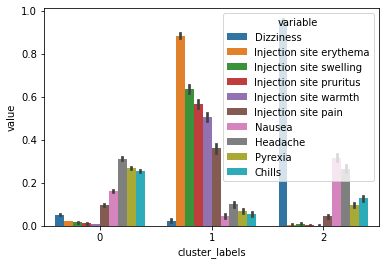

In [122]:
print_interpret_clusters(pred_y_birch, cluster_data)

* [13332] Cluster 0, no main symptoms 
* [4893] Cluster 1, fever, chills, pain, headache and fatigue 
* [2691] Cluster 2, only injection site reactions
* [3813] Cluster 3, mainly headache, ~20% chills, fever and pain
* [4324] Cluster 4, Fatigue, headache, ~20% chills, fever and pain

Silhoutte Score: 0.07018289456937489
DB Score: 3.069578031196215

[[    0     1     2     3     4]
 [ 3712    85  2885 20118  2253]]


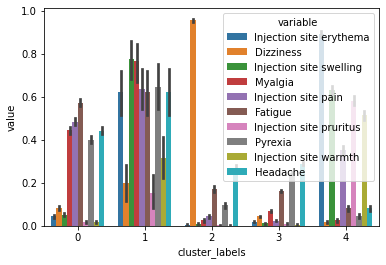

In [123]:
brc = Birch(branching_factor=50, n_clusters=5, threshold=1.5)
pred_y_birch5 = brc.fit_predict(cluster_data)

# Silhouette Score
print('Silhoutte Score: {}'.format(silhouette_score(cluster_data, pred_y_birch5)))
print('DB Score: {}\n'.format(davies_bouldin_score(cluster_data, pred_y_birch5)))

print_interpret_clusters(pred_y_birch5, cluster_data)

### - Model: DBSCAN Clustering

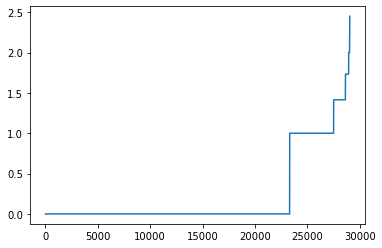

In [124]:
# first find optimal value of epsilon, which is the point of max curvature
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(cluster_data)
distances, indices = nbrs.kneighbors(cluster_data)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [125]:
from sklearn.cluster import DBSCAN

min_samples = cluster_data.shape[1]+1 #  Rule of thumb; number of dimensions D in the data set, as minPts ≥ D + 1
dbscan = DBSCAN(eps=1, min_samples=min_samples)
pred_y_dbscan = dbscan.fit_predict(cluster_data)

# Silhouette Score
print('Silhoutte Score: {}'.format(silhouette_score(cluster_data, pred_y_dbscan)))
print('DB Score : {}\n'.format(davies_bouldin_score(cluster_data, pred_y_birch)))

unique_elements, counts_elements = np.unique(pred_y_dbscan, return_counts = True)
print(np.asarray((unique_elements, counts_elements)))

Silhoutte Score: 0.21293894606573366
DB Score : 2.5255455678893637

[[   -1     0]
 [ 2685 26368]]


In [126]:
#DBSCAN Creates only few clusters... not useful for this purpose

### Spectral Clustering

In [132]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score

In [133]:
%%time

all_predictions=[]

num_cluster = [3, 4, 5]

for n in num_cluster:
    spectral_cl = SpectralClustering(n_clusters=n, 
                            assign_labels='discretize', random_state=42)

    pred_clusters = spectral_cl.fit_predict(cluster_data)
    all_predictions.append(pred_clusters)
    
    # Silhouette Score
    print('Silhouette Score Spectral: {:.3f}'.format(silhouette_score(cluster_data, pred_clusters)))
    print('DB Score : {:.3f}'.format(davies_bouldin_score(cluster_data, pred_clusters)))
    
    # Number of patients in each cluster
    unique_elements, counts_elements = np.unique(pred_clusters, return_counts = True)
    print(np.asarray((unique_elements, counts_elements)))
    print()

Silhouette Score Spectral: 0.137
DB Score : 2.322
[[    0     1     2]
 [18242  8427  2384]]

Silhouette Score Spectral: 0.136
DB Score : 1.992
[[    0     1     2     3]
 [18242  8425  2382     4]]

Silhouette Score Spectral: 0.104
DB Score : 2.339
[[    0     1     2     3     4]
 [12681  6969  2297  7102     4]]

Wall time: 33min 8s


The highest score is for cluster = 3

Silhouette Score Spectral: 0.137
DB Score: 2.322

[[    0     1     2]
 [18242  8427  2384]]

Wall time: 10min 22s


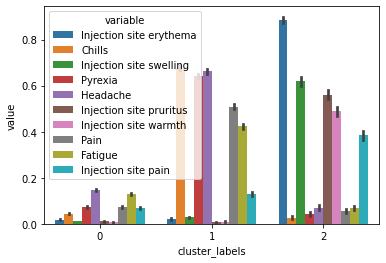

In [134]:
%%time
spectral_cl = SpectralClustering(n_clusters=3, 
                            assign_labels='discretize', random_state=42)

pred_sp = spectral_cl.fit_predict(cluster_data)

# Silhouette Score
print('Silhouette Score Spectral: {:.3f}'.format(silhouette_score(cluster_data, pred_sp)))
print('DB Score: {:.3f}\n'.format(davies_bouldin_score(cluster_data, pred_sp)))

print_interpret_clusters(pred_sp, cluster_data)
print()

* [18242] cluster 0 : almost no symptoms, some headaches and fatigue 
* [8427] cluster 1 : chills, fever, headache, pain, fatigue
* [2384] cluster 2 : injection site symptoms (itch, redness, swelling, warmt, pain) 

#### Spectral cluster n=4

Silhouette Score Spectral: 0.136
DB Score: 1.992

[[    0     1     2     3]
 [18242  8425  2382     4]]

Wall time: 9min 32s


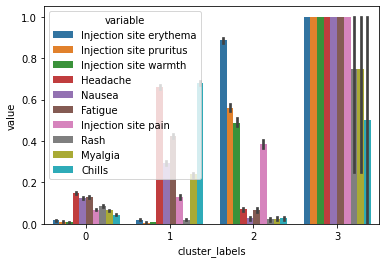

In [135]:
%%time
spectral_cl = SpectralClustering(n_clusters=4, 
                           assign_labels='discretize', random_state=42)

pred_sp4 = spectral_cl.fit_predict(cluster_data)

# Silhouette Score
print('Silhouette Score Spectral: {:.3f}'.format(silhouette_score(cluster_data, pred_sp4)))
print('DB Score: {:.3f}\n'.format(davies_bouldin_score(cluster_data, pred_sp4)))

print_interpret_clusters(pred_sp4, cluster_data)
print()

We can see how the last cluster of spectral clustering has only 4 samples and could be reduced to 3 clusters with the same characteristics from the results with 3 clusters. Spectral clustering with 5 clusters is expected to have very similar behavior as with 4 clusters.

### Gaussian Mixture

In [136]:
%%time

from sklearn.mixture import GaussianMixture

all_predictions=[]

num_cluster = [3, 4, 5]

for n in num_cluster:
    
    gm_cluster = GaussianMixture(n_components=n, covariance_type='full', random_state=42)

    pred_clusters = gm_cluster.fit_predict(cluster_data)
    all_predictions.append(pred_clusters)
    
    # Silhouette Score
    print('Silhouette Score: {:.3f}'.format(silhouette_score(cluster_data, pred_clusters)))
    print('DB Score: {:.3f}'.format(davies_bouldin_score(cluster_data, pred_clusters)))
   
    # Number of patients in each cluster
    unique_elements, counts_elements = np.unique(pred_clusters, return_counts = True)
    print(np.asarray((unique_elements, counts_elements)))
    print()

Silhouette Score: 0.058
DB Score: 3.723
[[    0     1     2]
 [18349  9656  1048]]

Silhouette Score: 0.053
DB Score: 3.481
[[    0     1     2     3]
 [18395  8921   904   833]]

Silhouette Score: 0.078
DB Score: 3.577
[[    0     1     2     3     4]
 [ 4958 13265  1889  4314  4627]]

Wall time: 39.2 s


#### Gaussian Mixtures with 3 clusters

Silhouette Score: 0.058
DB Score: 3.723
[[    0     1     2]
 [18349  9656  1048]]


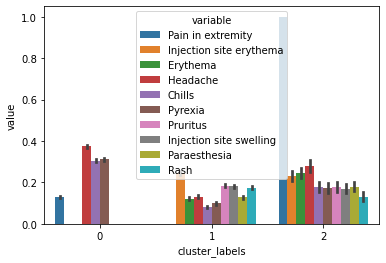

In [137]:
gm_cluster = GaussianMixture(n_components=3, covariance_type='full', random_state=42)

pred_gauss3 = gm_cluster.fit_predict(cluster_data)

# Silhouette Score
print('Silhouette Score: {:.3f}'.format(silhouette_score(cluster_data, pred_gauss3)))
print('DB Score: {:.3f}'.format(davies_bouldin_score(cluster_data, pred_gauss3)))
   

print_interpret_clusters(pred_gauss3, cluster_data)

These clusters seem to have overlaping symptoms with close values. We will disregard these results 

### Gaussian Mixtures with 5 clusters

[[    0     1     2     3     4]
 [ 4958 13265  1889  4314  4627]]


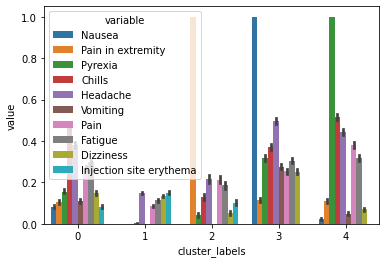

In [138]:
gm_cluster = GaussianMixture(n_components=5, covariance_type='full', random_state=42)

pred_gauss5 = gm_cluster.fit_predict(cluster_data)

print_interpret_clusters(pred_gauss5, cluster_data)

Using 5 clusters in Gaussian Mixtures we can see how the clusters overlap in features like headache (purple), chills (red), fatigue(gray) and pain (pink). The clusters are not clearly separated.

We will disregard the results from the Gaussian mixture algorithm

### - Model: Agglomerative

In [139]:
from sklearn.cluster import AgglomerativeClustering

In [140]:
%%time
from sklearn.cluster import AgglomerativeClustering

agglomerative = AgglomerativeClustering(n_clusters=2)
pred_y_agglomerative = agglomerative.fit_predict(cluster_data)

# Silhouette Score
print('Affinity Propagation: {}'.format(silhouette_score(cluster_data, pred_y_agglomerative)))

Affinity Propagation: 0.10291866817555377
Wall time: 1min 11s


In [141]:
%%time
from matplotlib import pyplot
from numpy import unique
from numpy import where
from sklearn.cluster import AgglomerativeClustering

range_n_clusters = range(3,6)
#sil_score = []

for k in range_n_clusters:
    agglomerative = AgglomerativeClustering(n_clusters=k)
    pred_y_agglomerative = agglomerative.fit_predict(cluster_data)
    score = silhouette_score(cluster_data, pred_y_agglomerative)
    print("For n_clusters =", k,
          "The average silhouette_score is :", score)
    #sil_score.append(score)

For n_clusters = 3 The average silhouette_score is : 0.06912384728059194
For n_clusters = 4 The average silhouette_score is : 0.07069402081486571
For n_clusters = 5 The average silhouette_score is : 0.04527529600672926
Wall time: 3min 29s


#### Agglomerative clusters = 3

[[    0     1     2]
 [12383  2880 13790]]


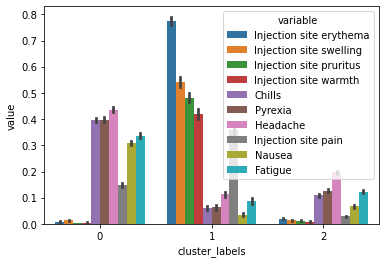

In [142]:
agglomerative = AgglomerativeClustering(n_clusters=3)
pred_y_agglomerative3 = agglomerative.fit_predict(cluster_data)

print_interpret_clusters(pred_y_agglomerative3, cluster_data)

* [12383] cluster 0: chills, fever, headache, fatigue, nausea
* [2880] cluster 1: injection site symptoms (itch, redness, swelling, warmth, pain)
* [13790] cluster 2: almost no symptoms, some headache and fatigue 

#### Agglomerative clusters = 5

[[    0     1     2     3     4]
 [ 9132  3370 10420  2880  3251]]


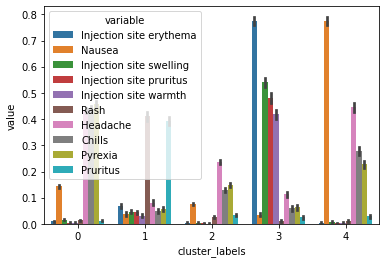

In [143]:
from sklearn.cluster import AgglomerativeClustering

agglomerative = AgglomerativeClustering(n_clusters=5)
pred_y_agglomerative5 = agglomerative.fit_predict(cluster_data)

print_interpret_clusters(pred_y_agglomerative5, cluster_data)

* [9132] cluster 0: headache, chills, fever, some nausea
* [3370] cluster 1: rash and itching 
* [10420] cluster 2: almost no symptoms, ~20% had headache ~10% chills, fever
* [2880] cluster 3: injection site symptoms
* [3251] cluster 4: Nausea, headache, ~20% chills, fever

In [ ]:
%%time
# visualizing clusters with T-SNE: used for high-dimensional data like ours

from sklearn.manifold import TSNE

def prepare_tsne(n_components, data, kmeans_labels):
    names = ['x', 'y', 'z']
    matrix = TSNE(n_components=n_components).fit_transform(data)
    df_matrix = pd.DataFrame(matrix)
    df_matrix.rename({i:names[i] for i in range(n_components)}, axis=1, inplace=True)
    df_matrix['labels'] = kmeans_labels
    return df_matrix
    
def plot_animation(df, label_column, name):
    def update(num):
        ax.view_init(200, num)

    N=360
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(tsne_3d_df['x'], tsne_3d_df['y'], tsne_3d_df['z'], c=tsne_3d_df[label_column],
               s=6, depthshade=True, cmap='Paired')
    ax.set_zlim(-15, 25)
    ax.set_xlim(-20, 20)
    plt.tight_layout()
    ani = animation.FuncAnimation(fig, update, N, blit=False, interval=50)
    ani.save('{}.gif'.format(name), writer='imagemagick')
    plt.show()
    
tsne_3d_df = prepare_tsne(3, cluster_data, pred_y_agglomerative5)
plot_animation(tsne_3d_df, 'labels', 'Agglomerative')
# tfne_3d_df

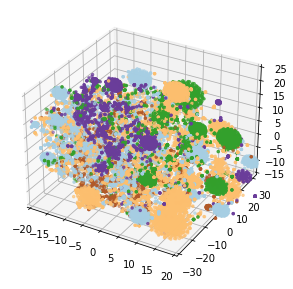

In [144]:
# Store the clean dataset with the kmeans cluster labels 
# to be used for further analysis in R 
df_clusters = df_merge.copy()
df_clusters['kmeans_5'] = pred_y_kmeans
df_clusters['kmeans_3'] = pred_y_kmeans3

df_clusters.to_csv('cleaned_data_clusters.csv', encoding='utf-8')